# Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np

# Runnning this cell for the first time requires downloading wordnet
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.models import Phrases
from gensim.utils import any2unicode 
from gensim.matutils import corpus2dense
from gensim.corpora import Dictionary
from transformers import RobertaTokenizerFast

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch.distributions as td

from analysis_steps import make_run_overview_df
from utils import load_checkpoint_model_for_eval

# Some globals

In [2]:
CODE_DIR = "/home/cbarkhof/fall-2021"
ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
CHECKPOINT_DIR = f"{CODE_DIR}/run_files/checkpoints"

SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

SURPRISAL_SAMPLE_FILE = "surprisal_sample.pt"
SURPRISAL_DATA_FILE = "surprisal_data.pt"
SURPRISAL_COND_SAMPLE_FILE = "surprisal_conditional_sample.pt"

TEST_VALID_EVAL_FILE = "test-valid-results.pt"

BASE_ALPHA = 0.001
MMD_REDO_FILE = f"mmd_redo-base-alpha-{BASE_ALPHA}.pt"

# Fetch relevant runs for language models

In [3]:
prefixes = ["(29-nov ptb-beta-vae)", "(29-nov yahoo-beta-vae)", "(29-nov drop yahoo-beta-vae)"]
overview_df = make_run_overview_df(prefixes, add_data_group=False)
overview_df

,objective,dataset,l_rate,dropout,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.500000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.5] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,1,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=1.0] | ST...


# Collect (un)conditional generative samples from models

In [4]:
max_samples = -1

ptb_model_text_samples = dict()
yahoo_model_text_samples = dict()

for i, (clean_name, row) in enumerate(overview_df.iterrows()):
    print(i, clean_name)
    
    save_dir = f"{ANALYSIS_DIR}/{row.run_name}"
    conditional_sample_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
    sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
    res = dict()
    
    if os.path.exists(conditional_sample_file):
        cond_samples = torch.load(conditional_sample_file)
        res["conditional_original_text"] = cond_samples["valid"]["condtional_sample_text"][:max_samples]
        res["conditional_sampled_text"] = cond_samples["valid"]["condtional_sample_text"][:max_samples]
    
    if os.path.exists(sample_file):
        samples = torch.load(sample_file)
        res["unconditional"] = samples["text"][:max_samples] 
        
    if "ptb" in clean_name:
        ptb_model_text_samples[clean_name] = res
    else:
        yahoo_model_text_samples[clean_name] = res

0 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
1 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
2 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa
3 yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa
4 yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa
5 yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa
6 yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa
7 yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa
8 yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa
9 yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa
10 yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa
11 yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa
12 yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa
13 yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa
14 yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa
15 yahoo_answer | dro

# Collect Yahoo & PTB train & validation data

In [10]:
from datasets import load_dataset, ReadInstruction

N_max_samples = 10000

# PENN TREE BANK
ptb_train_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="train")
ptb_train_text_samples = ptb_train_dataset["sentence"][:N_max_samples]

ptb_valid_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="validation")
ptb_valid_text_samples = ptb_valid_dataset["sentence"][:N_max_samples]

print("PTB")
print(f"Len train samples", len(ptb_train_text_samples))
print(f"Example train sample:\n\n{ptb_train_text_samples[0]}")
print();print()
print(f"Len valid samples", len(ptb_valid_text_samples))
print(f"Example valid sample:\n\n{ptb_valid_text_samples[0]}")

# YAHOO ANSWER
yahoo_train_dataset = load_dataset("yahoo_answers_topics", split=ReadInstruction('train', from_=0, to=10, unit='%'))
yahoo_train_text_samples = yahoo_train_dataset["best_answer"][:N_max_samples]

yahoo_valid_dataset = load_dataset("yahoo_answers_topics", split=ReadInstruction('test', from_=0, to=20, unit='%'))
yahoo_valid_text_samples = yahoo_valid_dataset["best_answer"][:N_max_samples]

print("YAHOO ANSWER")
print(f"Len train samples", len(yahoo_train_text_samples))
print(f"Example train sample:\n\n{yahoo_train_text_samples[0]}")
print();print()
print(f"Len valid samples", len(yahoo_valid_text_samples))
print(f"Example valid sample:\n\n{yahoo_valid_text_samples[0]}")

W1209 14:25:57.171059 23190345928448 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)
W1209 14:25:57.758161 23190345928448 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)


PTB
Len train samples 10000
Example train sample:

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter


Len valid samples 3370
Example valid sample:

consumers may want to move their telephones a little closer to the tv set


W1209 14:25:58.262070 23190345928448 builder.py:539] Reusing dataset yahoo_answers_topics (/home/cbarkhof/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
W1209 14:25:59.043339 23190345928448 builder.py:539] Reusing dataset yahoo_answers_topics (/home/cbarkhof/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


YAHOO ANSWER
Len train samples 10000
Example train sample:

Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.


Len valid samples 10000
Example valid sample:

good communication is what does it.  Can you move beyond small talk a

# Pre-process for LDA
### Determine vocabulary and train corpora for PTB & Yahoo

In [ ]:
def create_lda_corpus(text_samples):
    docs = []
    for text_string in text_samples:
        unicode_text_string = any2unicode(text_string, encoding='utf8', errors='strict')
        docs.append(unicode_text_string)

    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    # Remove stop words.
    stop_words = set(stopwords.words('english'))
    docs = [[token for token in doc if token not in stop_words] for doc in docs]

    # Lemmatize the documents
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)


    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=5, no_above=0.1)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    num_tokens = len(dictionary)
    dense_corpus = corpus2dense(corpus, num_terms=num_tokens, dtype=np.int64)
    
    return dictionary, corpus, dense_corpus.T, docs, num_tokens

In [12]:
# YAHOO
yahoo_train_dictionary, yahoo_train_corpus, _, yahoo_train_docs, yahoo_num_tokens = create_lda_corpus(
    yahoo_train_text_samples)

# PTB
ptb_train_dictionary, ptb_train_corpus, _, ptb_train_docs, ptb_num_tokens = create_lda_corpus(
    ptb_train_text_samples)

I1209 14:27:18.870332 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:27:18.874019 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:27:19.536759 23190345928448 phrases.py:609] collected 292262 token types (unigram + bigrams) from a corpus of 333869 words and 10000 sentences
I1209 14:27:19.538191 23190345928448 phrases.py:666] merged Phrases<292262 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
I1209 14:27:19.539417 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<292262 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.67s', 'datetime': '2021-12-09T14:27:19.539344', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:27:20.710179 23190345928448 dictionary.py:199] adding document #0 to Dictionary(0 unique tok

Number of unique tokens: 6811
Number of documents: 10000


I1209 14:27:23.932114 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:27:23.933557 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:27:24.167909 23190345928448 phrases.py:609] collected 82407 token types (unigram + bigrams) from a corpus of 121114 words and 10000 sentences
I1209 14:27:24.169269 23190345928448 phrases.py:666] merged Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
I1209 14:27:24.170451 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.24s', 'datetime': '2021-12-09T14:27:24.170407', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:27:24.595243 23190345928448 dictionary.py:199] adding document #0 to Dictionary(0 unique tokens

Number of unique tokens: 3743
Number of documents: 10000


In [13]:
def lda_preprocess(dictionary, text_samples):
    docs = []
    for text_string in text_samples:
        unicode_text_string = any2unicode(text_string, encoding='utf8', errors='strict')
        docs.append(unicode_text_string)

    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    # Remove stop words.
    stop_words = set(stopwords.words('english'))
    docs = [[token for token in doc if token not in stop_words] for doc in docs]

    # Lemmatize the documents
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (all of them, dictionary will decide which ones stay)
    # TODO: check if this is correct, should it not add all bigrams then?
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    
    output_docs = []
    for doc in docs:
        new_doc = []
        for token in doc:
            # if token in vocab
            if token in dictionary.token2id: # and token not in new_doc: (there actually may be duplicates!)
                new_doc.append(token)
        output_docs.append(new_doc)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in output_docs]

    return corpus, output_docs

# Pre-process / transform (non-train) model samples

In [20]:
# PTB
ptb_model_samples_transformed = dict()
for i, (model_name, model_samples) in enumerate(ptb_model_text_samples.items()):
    
    ptb_model_samples_transformed[model_name] = dict()
    for cond in ["conditional_original_text", "conditional_sampled_text", "unconditional"]:
        s = model_samples[cond]
        c, d = lda_preprocess(ptb_train_dictionary, s)
        ptb_model_samples_transformed[model_name][cond] = {
            "corpus": c,
            "docs": d,
            "text_samples": s
        }
    print(i, len(s), model_name)

# YAHOO
yahoo_model_samples_transformed = dict()
for i, (model_name, model_samples) in enumerate(yahoo_model_text_samples.items()):
    yahoo_model_samples_transformed[model_name] = dict()
    for cond in ["conditional_original_text", "conditional_sampled_text", "unconditional"]:
        s = model_samples[cond]
        c, d = lda_preprocess(yahoo_train_dictionary, s)
        yahoo_model_samples_transformed[model_name][cond] = {
            "corpus": c,
            "docs": d,
            "text_samples": s
        }
    print(i, len(s), model_name)
    
print(len(yahoo_model_samples_transformed), len(yahoo_model_samples_transformed))
print(len(ptb_model_samples_transformed), len(ptb_model_samples_transformed))

I1209 14:32:39.645082 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:39.646545 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:39.716918 23190345928448 phrases.py:609] collected 33455 token types (unigram + bigrams) from a corpus of 37127 words and 3071 sentences
I1209 14:32:39.718089 23190345928448 phrases.py:666] merged Phrases<33455 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:39.719172 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<33455 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.07s', 'datetime': '2021-12-09T14:32:39.719129', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:40.202814 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:40.20

0 3071 ptb BETA-VAE beta 1.5 dec: Strong roBERTa


I1209 14:32:41.436380 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:41.437760 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:41.532901 23190345928448 phrases.py:609] collected 48209 token types (unigram + bigrams) from a corpus of 48657 words and 3071 sentences
I1209 14:32:41.534185 23190345928448 phrases.py:666] merged Phrases<48209 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:41.535243 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<48209 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:32:41.535200', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:42.136822 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:42.13

1 3071 ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa


I1209 14:32:43.505183 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:43.506533 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:43.583682 23190345928448 phrases.py:609] collected 34099 token types (unigram + bigrams) from a corpus of 38393 words and 3071 sentences
I1209 14:32:43.584901 23190345928448 phrases.py:666] merged Phrases<34099 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:43.589728 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<34099 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:32:43.589684', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:44.100110 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:44.10

2 3071 ptb BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:32:45.342099 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:45.343470 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:45.435909 23190345928448 phrases.py:609] collected 46586 token types (unigram + bigrams) from a corpus of 48403 words and 3071 sentences
I1209 14:32:45.437156 23190345928448 phrases.py:666] merged Phrases<46586 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:45.438231 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<46586 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:32:45.438187', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:46.043265 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:46.04

3 3071 ptb BETA-VAE beta 1 dec: Weak-M roBERTa


I1209 14:32:48.063514 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:48.064918 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:48.157396 23190345928448 phrases.py:609] collected 47260 token types (unigram + bigrams) from a corpus of 48322 words and 3071 sentences
I1209 14:32:48.158672 23190345928448 phrases.py:666] merged Phrases<47260 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:48.159719 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<47260 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:32:48.159677', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:48.770864 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:48.77

4 3071 ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa


I1209 14:32:50.167833 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:50.169233 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:50.250254 23190345928448 phrases.py:609] collected 34051 token types (unigram + bigrams) from a corpus of 38310 words and 3071 sentences
I1209 14:32:50.251493 23190345928448 phrases.py:666] merged Phrases<34051 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:50.252565 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<34051 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:32:50.252516', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:50.770706 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:50.77

5 3071 ptb BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:32:51.982058 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:51.983391 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:52.060475 23190345928448 phrases.py:609] collected 36643 token types (unigram + bigrams) from a corpus of 40184 words and 3071 sentences
I1209 14:32:52.061640 23190345928448 phrases.py:666] merged Phrases<36643 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:52.062730 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<36643 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:32:52.062689', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:52.594403 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:52.59

6 3071 ptb BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:32:53.870622 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:53.872005 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:53.957507 23190345928448 phrases.py:609] collected 40526 token types (unigram + bigrams) from a corpus of 44342 words and 3071 sentences
I1209 14:32:53.958811 23190345928448 phrases.py:666] merged Phrases<40526 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:53.960086 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<40526 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:32:53.960043', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:54.562357 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:54.56

7 3071 ptb BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:32:55.866906 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:55.868253 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:55.938336 23190345928448 phrases.py:609] collected 36189 token types (unigram + bigrams) from a corpus of 36942 words and 3071 sentences
I1209 14:32:55.939482 23190345928448 phrases.py:666] merged Phrases<36189 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:55.940558 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<36189 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.07s', 'datetime': '2021-12-09T14:32:55.940516', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:56.997671 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:56.99

8 3071 ptb BETA-VAE beta 0 dec: Weak-M roBERTa


I1209 14:32:58.512234 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:58.513624 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:32:58.599913 23190345928448 phrases.py:609] collected 42354 token types (unigram + bigrams) from a corpus of 45521 words and 3071 sentences
I1209 14:32:58.601105 23190345928448 phrases.py:666] merged Phrases<42354 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:32:58.602190 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<42354 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:32:58.602147', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:32:59.197091 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:32:59.19

9 3071 ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa


I1209 14:33:00.677970 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:00.679493 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:00.778528 23190345928448 phrases.py:609] collected 53141 token types (unigram + bigrams) from a corpus of 49135 words and 3071 sentences
I1209 14:33:00.779722 23190345928448 phrases.py:666] merged Phrases<53141 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:00.780829 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<53141 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:00.780784', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:01.458549 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:01.45

0 3071 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:33:02.985651 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:02.987012 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:03.079855 23190345928448 phrases.py:609] collected 48897 token types (unigram + bigrams) from a corpus of 48374 words and 3071 sentences
I1209 14:33:03.081123 23190345928448 phrases.py:666] merged Phrases<48897 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:03.082211 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<48897 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:03.082168', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:03.747495 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:03.74

1 3071 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:33:05.224914 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:05.228532 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:05.311146 23190345928448 phrases.py:609] collected 45784 token types (unigram + bigrams) from a corpus of 43017 words and 3071 sentences
I1209 14:33:05.312401 23190345928448 phrases.py:666] merged Phrases<45784 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:05.313473 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<45784 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:33:05.313421', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:05.888030 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:05.88

2 3071 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:33:07.286005 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:07.287384 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:07.385007 23190345928448 phrases.py:609] collected 54932 token types (unigram + bigrams) from a corpus of 50443 words and 3071 sentences
I1209 14:33:07.386232 23190345928448 phrases.py:666] merged Phrases<54932 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:07.387309 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<54932 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:07.387265', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:08.528037 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:08.52

3 3071 yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:33:10.096760 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:10.098186 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:10.200945 23190345928448 phrases.py:609] collected 59375 token types (unigram + bigrams) from a corpus of 53517 words and 3071 sentences
I1209 14:33:10.202239 23190345928448 phrases.py:666] merged Phrases<59375 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:10.203463 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<59375 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:10.203419', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:10.920102 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:10.92

4 3071 yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:33:12.383526 23190345928448 phrases.py:609] collected 1222 token types (unigram + bigrams) from a corpus of 3436 words and 3071 sentences
I1209 14:33:12.384545 23190345928448 phrases.py:666] merged Phrases<1222 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:12.385671 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<1222 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2021-12-09T14:33:12.385633', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


5 3071 yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:33:12.743391 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:12.744569 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:12.820934 23190345928448 phrases.py:609] collected 41886 token types (unigram + bigrams) from a corpus of 38628 words and 3071 sentences
I1209 14:33:12.822274 23190345928448 phrases.py:666] merged Phrases<41886 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:12.827070 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<41886 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:33:12.827019', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:13.347867 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:13.34

6 3071 yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:33:14.556962 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:14.558356 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:14.638486 23190345928448 phrases.py:609] collected 45856 token types (unigram + bigrams) from a corpus of 41571 words and 3071 sentences
I1209 14:33:14.639712 23190345928448 phrases.py:666] merged Phrases<45856 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:14.640759 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<45856 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:33:14.640716', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:15.218415 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:15.21

7 3071 yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:33:16.535034 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:16.536400 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:16.635262 23190345928448 phrases.py:609] collected 59099 token types (unigram + bigrams) from a corpus of 51064 words and 3071 sentences
I1209 14:33:16.636488 23190345928448 phrases.py:666] merged Phrases<59099 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:16.637556 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<59099 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:16.637512', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:17.311331 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:17.31

8 3071 yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:33:19.516002 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:19.517361 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:19.608311 23190345928448 phrases.py:609] collected 57210 token types (unigram + bigrams) from a corpus of 47407 words and 3071 sentences
I1209 14:33:19.609585 23190345928448 phrases.py:666] merged Phrases<57210 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:19.610740 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<57210 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:33:19.610698', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:20.261018 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:20.26

9 3071 yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:33:21.684965 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:21.686331 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:21.763449 23190345928448 phrases.py:609] collected 44459 token types (unigram + bigrams) from a corpus of 40148 words and 3071 sentences
I1209 14:33:21.764620 23190345928448 phrases.py:666] merged Phrases<44459 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:21.765804 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<44459 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:33:21.765761', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:22.310652 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:22.31

10 3071 yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:33:23.610598 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:23.611962 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:23.702350 23190345928448 phrases.py:609] collected 50826 token types (unigram + bigrams) from a corpus of 47231 words and 3071 sentences
I1209 14:33:23.703589 23190345928448 phrases.py:666] merged Phrases<50826 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:23.704630 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<50826 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:33:23.704588', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:24.347471 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:24.35

11 3071 yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:33:25.892240 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:25.893674 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:26.005093 23190345928448 phrases.py:609] collected 59488 token types (unigram + bigrams) from a corpus of 55232 words and 3071 sentences
I1209 14:33:26.006387 23190345928448 phrases.py:666] merged Phrases<59488 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:26.011413 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<59488 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.12s', 'datetime': '2021-12-09T14:33:26.011360', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:26.748065 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:26.74

12 3071 yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:33:28.277917 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:28.279175 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:28.336437 23190345928448 phrases.py:609] collected 36347 token types (unigram + bigrams) from a corpus of 31228 words and 3071 sentences
I1209 14:33:28.337687 23190345928448 phrases.py:666] merged Phrases<36347 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:28.338978 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<36347 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.06s', 'datetime': '2021-12-09T14:33:28.338935', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:28.770172 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:28.77

13 3071 yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:33:29.809301 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:29.810635 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:29.870410 23190345928448 phrases.py:609] collected 35380 token types (unigram + bigrams) from a corpus of 32537 words and 3071 sentences
I1209 14:33:29.871587 23190345928448 phrases.py:666] merged Phrases<35380 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:29.872617 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<35380 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.06s', 'datetime': '2021-12-09T14:33:29.872573', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:30.331552 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:30.33

14 3071 yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:33:31.990272 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:31.991591 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:32.058820 23190345928448 phrases.py:609] collected 40476 token types (unigram + bigrams) from a corpus of 36849 words and 3071 sentences
I1209 14:33:32.059981 23190345928448 phrases.py:666] merged Phrases<40476 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:32.061150 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<40476 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.07s', 'datetime': '2021-12-09T14:33:32.061108', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:32.563205 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:32.56

15 3071 yahoo_answer | drop-0.5 | BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:33:33.803915 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:33.805275 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:33.895877 23190345928448 phrases.py:609] collected 51276 token types (unigram + bigrams) from a corpus of 47110 words and 3071 sentences
I1209 14:33:33.897122 23190345928448 phrases.py:666] merged Phrases<51276 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:33.898325 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<51276 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.09s', 'datetime': '2021-12-09T14:33:33.898283', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:34.537207 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:34.53

16 3071 yahoo_answer BETA-VAE beta 1.5 dec: Strong roBERTa


I1209 14:33:36.099986 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:36.101381 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:36.207250 23190345928448 phrases.py:609] collected 59992 token types (unigram + bigrams) from a corpus of 55169 words and 3071 sentences
I1209 14:33:36.208724 23190345928448 phrases.py:666] merged Phrases<59992 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:36.210018 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<59992 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:36.209974', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:36.949293 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:36.95

17 3071 yahoo_answer BETA-VAE beta 1 dec: Strong roBERTa


I1209 14:33:38.556406 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:38.557816 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:38.637582 23190345928448 phrases.py:609] collected 45672 token types (unigram + bigrams) from a corpus of 41950 words and 3071 sentences
I1209 14:33:38.638779 23190345928448 phrases.py:666] merged Phrases<45672 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:38.639816 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<45672 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:33:38.639774', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:39.189410 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:39.19

18 3071 yahoo_answer BETA-VAE beta 1.5 dec: Weak-M roBERTa


I1209 14:33:40.445943 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:40.447334 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:40.525422 23190345928448 phrases.py:609] collected 47446 token types (unigram + bigrams) from a corpus of 41287 words and 3071 sentences
I1209 14:33:40.526640 23190345928448 phrases.py:666] merged Phrases<47446 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:40.527699 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<47446 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:33:40.527655', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:41.065832 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:41.06

19 3071 yahoo_answer BETA-VAE beta 1 dec: Weak-M roBERTa


I1209 14:33:42.440370 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:42.441773 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:42.547206 23190345928448 phrases.py:609] collected 57700 token types (unigram + bigrams) from a corpus of 54266 words and 3071 sentences
I1209 14:33:42.548497 23190345928448 phrases.py:666] merged Phrases<57700 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:42.549728 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<57700 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:42.549669', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:43.308163 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:43.30

20 3071 yahoo_answer BETA-VAE beta 0.5 dec: Strong roBERTa


I1209 14:33:45.752553 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:45.753982 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:45.845787 23190345928448 phrases.py:609] collected 53748 token types (unigram + bigrams) from a corpus of 47837 words and 3071 sentences
I1209 14:33:45.847060 23190345928448 phrases.py:666] merged Phrases<53748 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:45.848256 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<53748 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:45.848213', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:46.483710 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:46.48

21 3071 yahoo_answer BETA-VAE beta 0.5 dec: Weak-M roBERTa


I1209 14:33:47.907940 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:47.909348 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:48.018493 23190345928448 phrases.py:609] collected 60004 token types (unigram + bigrams) from a corpus of 54744 words and 3071 sentences
I1209 14:33:48.019875 23190345928448 phrases.py:666] merged Phrases<60004 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:48.021029 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<60004 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:48.020985', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:48.743293 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:48.74

22 3071 yahoo_answer BETA-VAE beta 0.1 dec: Strong roBERTa


I1209 14:33:50.420796 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:50.422231 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:50.523685 23190345928448 phrases.py:609] collected 58775 token types (unigram + bigrams) from a corpus of 52456 words and 3071 sentences
I1209 14:33:50.525080 23190345928448 phrases.py:666] merged Phrases<58775 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:50.526165 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<58775 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:50.526122', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:51.205850 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:51.20

23 3071 yahoo_answer BETA-VAE beta 0.1 dec: Weak-M roBERTa


I1209 14:33:52.659160 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:52.663029 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:52.767740 23190345928448 phrases.py:609] collected 62911 token types (unigram + bigrams) from a corpus of 53651 words and 3071 sentences
I1209 14:33:52.768967 23190345928448 phrases.py:666] merged Phrases<62911 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:52.770250 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<62911 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-12-09T14:33:52.770160', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:53.480312 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:53.48

24 3071 yahoo_answer BETA-VAE beta 0 dec: Strong roBERTa


I1209 14:33:55.002311 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:55.003675 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:33:55.095590 23190345928448 phrases.py:609] collected 54663 token types (unigram + bigrams) from a corpus of 47828 words and 3071 sentences
I1209 14:33:55.096868 23190345928448 phrases.py:666] merged Phrases<54663 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:33:55.098061 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<54663 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2021-12-09T14:33:55.098018', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:33:55.734714 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:33:55.73

25 3071 yahoo_answer BETA-VAE beta 0 dec: Weak-M roBERTa
26 26
10 10


# Train LDA model for PTB & Yahoo

In [21]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 600
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp1 = ptb_train_dictionary[0]  # This is only to "load" the dictionary.
temp2 = yahoo_train_dictionary[0]  # This is only to "load" the dictionary.

ptb_id2word = ptb_train_dictionary.id2token
yahoo_id2word = yahoo_train_dictionary.id2token

ptb_lda_model = LdaModel(
    corpus=ptb_train_corpus,
    id2word=ptb_id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

yahoo_lda_model = LdaModel(
    corpus=yahoo_train_corpus,
    id2word=yahoo_id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

I1209 14:34:21.574330 23190345928448 ldamodel.py:595] using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
I1209 14:34:21.576989 23190345928448 ldamodel.py:481] using serial LDA version on this node
I1209 14:34:21.585962 23190345928448 ldamodel.py:954] running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 600x with a convergence threshold of 0.001000
I1209 14:34:21.587730 23190345928448 ldamodel.py:1003] PROGRESS: pass 0, at document #2000/10000
I1209 14:34:23.345232 23190345928448 ldamodel.py:794] optimized alpha [0.080897085, 0.07857816, 0.08518664, 0.08473297, 0.08043633, 0.082386866, 0.08278085, 0.08371955, 0.07975655, 0.081452504]
I1209 14:34:23.349671 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:23.355428 23190345928448 ldamodel.py:119

I1209 14:34:28.007868 23190345928448 ldamodel.py:1196] topic #6 (0.097): 0.022*"company" + 0.015*"mr" + 0.011*"inc" + 0.010*"group" + 0.010*"year" + 0.009*"million" + 0.009*"agreement" + 0.008*"co" + 0.007*"plan" + 0.007*"also"
I1209 14:34:28.009087 23190345928448 ldamodel.py:1196] topic #2 (0.101): 0.013*"would" + 0.011*"million" + 0.009*"company" + 0.009*"rate" + 0.009*"share" + 0.008*"market" + 0.007*"say" + 0.007*"mr" + 0.007*"soviet" + 0.007*"one"
I1209 14:34:28.010249 23190345928448 ldamodel.py:1074] topic diff=0.374487, rho=0.447214
I1209 14:34:28.022020 23190345928448 ldamodel.py:1003] PROGRESS: pass 1, at document #2000/10000
I1209 14:34:29.038263 23190345928448 ldamodel.py:794] optimized alpha [0.08827064, 0.08197013, 0.09880544, 0.092040576, 0.08453022, 0.08981995, 0.09533292, 0.09309369, 0.082077526, 0.08216632]
I1209 14:34:29.042884 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:29.048675 23190345928448 ldamo

I1209 14:34:32.883826 23190345928448 ldamodel.py:1196] topic #6 (0.110): 0.023*"company" + 0.014*"mr" + 0.011*"inc" + 0.011*"group" + 0.010*"million" + 0.009*"plan" + 0.009*"agreement" + 0.008*"corp" + 0.008*"year" + 0.008*"co"
I1209 14:34:32.885187 23190345928448 ldamodel.py:1196] topic #2 (0.111): 0.014*"would" + 0.010*"rate" + 0.010*"million" + 0.008*"market" + 0.008*"company" + 0.008*"soviet" + 0.008*"one" + 0.008*"share" + 0.007*"mr" + 0.007*"issue"
I1209 14:34:32.886354 23190345928448 ldamodel.py:1074] topic diff=0.241158, rho=0.377964
I1209 14:34:32.898395 23190345928448 ldamodel.py:1003] PROGRESS: pass 2, at document #2000/10000
I1209 14:34:33.830684 23190345928448 ldamodel.py:794] optimized alpha [0.09701484, 0.08816064, 0.10973257, 0.101537906, 0.09043419, 0.101608895, 0.10832023, 0.102574624, 0.08805759, 0.08763528]
I1209 14:34:33.835164 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:33.840775 23190345928448 ld

I1209 14:34:37.502568 23190345928448 ldamodel.py:1196] topic #2 (0.123): 0.014*"would" + 0.011*"rate" + 0.010*"million" + 0.009*"market" + 0.009*"soviet" + 0.008*"one" + 0.008*"issue" + 0.008*"bond" + 0.007*"big" + 0.007*"mr"
I1209 14:34:37.503538 23190345928448 ldamodel.py:1196] topic #6 (0.124): 0.024*"company" + 0.013*"mr" + 0.011*"inc" + 0.011*"group" + 0.010*"plan" + 0.010*"million" + 0.010*"corp" + 0.009*"agreement" + 0.008*"co" + 0.007*"would"
I1209 14:34:37.504993 23190345928448 ldamodel.py:1074] topic diff=0.175616, rho=0.353553
I1209 14:34:37.515564 23190345928448 ldamodel.py:1003] PROGRESS: pass 3, at document #2000/10000
I1209 14:34:38.403577 23190345928448 ldamodel.py:794] optimized alpha [0.10702335, 0.09558405, 0.12276906, 0.112869, 0.09743703, 0.11451342, 0.12219529, 0.112726726, 0.095654376, 0.09486417]
I1209 14:34:38.408041 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:38.413693 23190345928448 ldamodel.

I1209 14:34:41.929578 23190345928448 ldamodel.py:1196] topic #2 (0.137): 0.014*"would" + 0.010*"rate" + 0.010*"million" + 0.009*"soviet" + 0.009*"market" + 0.009*"bond" + 0.008*"issue" + 0.008*"big" + 0.007*"investor" + 0.007*"yield"
I1209 14:34:41.930798 23190345928448 ldamodel.py:1196] topic #6 (0.138): 0.026*"company" + 0.013*"mr" + 0.012*"inc" + 0.011*"plan" + 0.011*"group" + 0.011*"corp" + 0.010*"million" + 0.009*"agreement" + 0.008*"co" + 0.007*"would"
I1209 14:34:41.931944 23190345928448 ldamodel.py:1074] topic diff=0.126806, rho=0.333333
I1209 14:34:41.942491 23190345928448 ldamodel.py:1003] PROGRESS: pass 4, at document #2000/10000
I1209 14:34:42.808368 23190345928448 ldamodel.py:794] optimized alpha [0.1172438, 0.103437044, 0.13683413, 0.12480192, 0.104847424, 0.12785287, 0.13605085, 0.123364896, 0.10389911, 0.10335117]
I1209 14:34:42.812959 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:42.818713 23190345928448

I1209 14:34:46.250245 23190345928448 ldamodel.py:1196] topic #2 (0.151): 0.014*"would" + 0.011*"bond" + 0.010*"rate" + 0.010*"million" + 0.010*"soviet" + 0.009*"market" + 0.009*"issue" + 0.008*"yield" + 0.008*"union" + 0.008*"big"
I1209 14:34:46.251159 23190345928448 ldamodel.py:1196] topic #6 (0.152): 0.026*"company" + 0.012*"mr" + 0.012*"plan" + 0.012*"inc" + 0.011*"corp" + 0.011*"group" + 0.011*"million" + 0.009*"agreement" + 0.009*"co" + 0.008*"would"
I1209 14:34:46.252739 23190345928448 ldamodel.py:1074] topic diff=0.098436, rho=0.316228
I1209 14:34:46.263364 23190345928448 ldamodel.py:1003] PROGRESS: pass 5, at document #2000/10000
I1209 14:34:47.110853 23190345928448 ldamodel.py:794] optimized alpha [0.12759805, 0.11170562, 0.15073557, 0.13700898, 0.112295814, 0.14181888, 0.14985664, 0.13399956, 0.112464495, 0.112345226]
I1209 14:34:47.115333 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:47.121001 23190345928448 l

I1209 14:34:50.556191 23190345928448 ldamodel.py:1196] topic #2 (0.165): 0.014*"would" + 0.012*"bond" + 0.010*"soviet" + 0.010*"rate" + 0.010*"million" + 0.009*"market" + 0.009*"issue" + 0.009*"yield" + 0.008*"union" + 0.008*"investor"
I1209 14:34:50.557543 23190345928448 ldamodel.py:1196] topic #6 (0.166): 0.027*"company" + 0.012*"plan" + 0.012*"mr" + 0.012*"inc" + 0.012*"corp" + 0.011*"million" + 0.011*"group" + 0.009*"co" + 0.009*"agreement" + 0.008*"would"
I1209 14:34:50.558772 23190345928448 ldamodel.py:1074] topic diff=0.081836, rho=0.301511
I1209 14:34:50.570745 23190345928448 ldamodel.py:1003] PROGRESS: pass 6, at document #2000/10000
I1209 14:34:51.401238 23190345928448 ldamodel.py:794] optimized alpha [0.1379292, 0.11985923, 0.16418613, 0.14940014, 0.11974729, 0.15565622, 0.16314453, 0.14462014, 0.120967165, 0.121429466]
I1209 14:34:51.405745 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:51.411350 2319034592844

I1209 14:34:54.818127 23190345928448 ldamodel.py:1196] topic #2 (0.179): 0.014*"would" + 0.013*"bond" + 0.010*"soviet" + 0.010*"market" + 0.009*"rate" + 0.009*"issue" + 0.009*"yield" + 0.009*"million" + 0.009*"investor" + 0.009*"union"
I1209 14:34:54.819237 23190345928448 ldamodel.py:1196] topic #6 (0.179): 0.028*"company" + 0.013*"plan" + 0.012*"corp" + 0.012*"million" + 0.012*"inc" + 0.012*"mr" + 0.011*"group" + 0.009*"co" + 0.009*"would" + 0.009*"agreement"
I1209 14:34:54.820414 23190345928448 ldamodel.py:1074] topic diff=0.072121, rho=0.288675
I1209 14:34:54.831888 23190345928448 ldamodel.py:1003] PROGRESS: pass 7, at document #2000/10000
I1209 14:34:55.671023 23190345928448 ldamodel.py:794] optimized alpha [0.14777598, 0.12756768, 0.1779632, 0.16184698, 0.1273235, 0.16914247, 0.17631908, 0.15497807, 0.12933439, 0.130434]
I1209 14:34:55.675623 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:55.681258 23190345928448 lda

I1209 14:34:59.066720 23190345928448 ldamodel.py:1196] topic #6 (0.192): 0.029*"company" + 0.013*"plan" + 0.012*"corp" + 0.012*"million" + 0.012*"inc" + 0.012*"mr" + 0.011*"group" + 0.009*"co" + 0.009*"would" + 0.008*"agreement"
I1209 14:34:59.067911 23190345928448 ldamodel.py:1196] topic #2 (0.192): 0.014*"would" + 0.014*"bond" + 0.010*"soviet" + 0.010*"market" + 0.010*"yield" + 0.010*"issue" + 0.009*"rate" + 0.009*"million" + 0.009*"investor" + 0.009*"union"
I1209 14:34:59.068851 23190345928448 ldamodel.py:1074] topic diff=0.065684, rho=0.277350
I1209 14:34:59.079602 23190345928448 ldamodel.py:1003] PROGRESS: pass 8, at document #2000/10000
I1209 14:34:59.928146 23190345928448 ldamodel.py:794] optimized alpha [0.15698363, 0.13510382, 0.19198342, 0.17367971, 0.1347648, 0.18288346, 0.1891938, 0.16497383, 0.13770068, 0.13903862]
I1209 14:34:59.932919 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:34:59.938334 23190345928448 l

I1209 14:35:03.317544 23190345928448 ldamodel.py:1196] topic #6 (0.205): 0.030*"company" + 0.013*"plan" + 0.012*"corp" + 0.012*"million" + 0.012*"inc" + 0.012*"mr" + 0.011*"group" + 0.009*"would" + 0.009*"co" + 0.008*"agreement"
I1209 14:35:03.319797 23190345928448 ldamodel.py:1196] topic #2 (0.207): 0.015*"bond" + 0.014*"would" + 0.010*"soviet" + 0.010*"issue" + 0.010*"market" + 0.010*"yield" + 0.009*"investor" + 0.009*"rate" + 0.009*"million" + 0.009*"union"
I1209 14:35:03.320936 23190345928448 ldamodel.py:1074] topic diff=0.060366, rho=0.267261
I1209 14:35:03.332021 23190345928448 ldamodel.py:1003] PROGRESS: pass 9, at document #2000/10000
I1209 14:35:04.172443 23190345928448 ldamodel.py:794] optimized alpha [0.16547431, 0.14235188, 0.20607765, 0.18493526, 0.14180902, 0.19713752, 0.20197539, 0.17434342, 0.14589308, 0.14743334]
I1209 14:35:04.177052 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:04.182483 23190345928448

I1209 14:35:07.607197 23190345928448 ldamodel.py:1196] topic #6 (0.218): 0.031*"company" + 0.013*"plan" + 0.012*"corp" + 0.012*"million" + 0.012*"inc" + 0.011*"mr" + 0.011*"group" + 0.009*"would" + 0.009*"co" + 0.008*"concern"
I1209 14:35:07.608376 23190345928448 ldamodel.py:1196] topic #2 (0.221): 0.016*"bond" + 0.014*"would" + 0.010*"soviet" + 0.010*"issue" + 0.010*"yield" + 0.010*"market" + 0.010*"investor" + 0.009*"rate" + 0.008*"union" + 0.008*"million"
I1209 14:35:07.609350 23190345928448 ldamodel.py:1074] topic diff=0.056194, rho=0.258199
I1209 14:35:07.618928 23190345928448 ldamodel.py:1003] PROGRESS: pass 10, at document #2000/10000
I1209 14:35:08.470046 23190345928448 ldamodel.py:794] optimized alpha [0.17337978, 0.14926825, 0.22038871, 0.19564739, 0.1485397, 0.21192126, 0.21442798, 0.18336317, 0.15372795, 0.15575607]
I1209 14:35:08.474696 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:08.480186 23190345928448 l

I1209 14:35:11.921446 23190345928448 ldamodel.py:1196] topic #6 (0.230): 0.031*"company" + 0.014*"plan" + 0.013*"corp" + 0.012*"million" + 0.012*"inc" + 0.011*"group" + 0.011*"mr" + 0.009*"would" + 0.009*"co" + 0.008*"concern"
I1209 14:35:11.922969 23190345928448 ldamodel.py:1196] topic #2 (0.235): 0.016*"bond" + 0.014*"would" + 0.011*"issue" + 0.011*"soviet" + 0.010*"yield" + 0.010*"market" + 0.010*"investor" + 0.009*"rate" + 0.008*"union" + 0.008*"japanese"
I1209 14:35:11.923828 23190345928448 ldamodel.py:1074] topic diff=0.052994, rho=0.250000
I1209 14:35:11.933533 23190345928448 ldamodel.py:1003] PROGRESS: pass 11, at document #2000/10000
I1209 14:35:12.790198 23190345928448 ldamodel.py:794] optimized alpha [0.18138127, 0.15596075, 0.23498839, 0.20602353, 0.15507825, 0.22692223, 0.22677861, 0.19231535, 0.16109902, 0.16390589]
I1209 14:35:12.794789 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:12.800609 23190345928448

I1209 14:35:16.281659 23190345928448 ldamodel.py:1196] topic #6 (0.243): 0.032*"company" + 0.014*"plan" + 0.013*"corp" + 0.012*"million" + 0.012*"inc" + 0.012*"group" + 0.011*"mr" + 0.010*"co" + 0.010*"would" + 0.008*"concern"
I1209 14:35:16.282862 23190345928448 ldamodel.py:1196] topic #2 (0.251): 0.016*"bond" + 0.014*"would" + 0.011*"issue" + 0.010*"soviet" + 0.010*"yield" + 0.010*"investor" + 0.010*"market" + 0.009*"rate" + 0.009*"japanese" + 0.008*"union"
I1209 14:35:16.283770 23190345928448 ldamodel.py:1074] topic diff=0.050164, rho=0.242536
I1209 14:35:16.294356 23190345928448 ldamodel.py:1003] PROGRESS: pass 12, at document #2000/10000
I1209 14:35:17.165607 23190345928448 ldamodel.py:794] optimized alpha [0.1890495, 0.16256106, 0.2505004, 0.2159236, 0.16137363, 0.24257189, 0.23919359, 0.20116319, 0.16835853, 0.17201775]
I1209 14:35:17.170074 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:17.175663 23190345928448 ld

I1209 14:35:20.653008 23190345928448 ldamodel.py:1196] topic #5 (0.258): 0.015*"mr" + 0.012*"people" + 0.011*"say" + 0.010*"next" + 0.010*"would" + 0.008*"may" + 0.008*"time" + 0.007*"take" + 0.007*"even" + 0.007*"report"
I1209 14:35:20.654489 23190345928448 ldamodel.py:1196] topic #2 (0.267): 0.016*"bond" + 0.014*"would" + 0.011*"issue" + 0.010*"yield" + 0.010*"soviet" + 0.010*"investor" + 0.010*"market" + 0.009*"japanese" + 0.009*"rate" + 0.008*"big"
I1209 14:35:20.655336 23190345928448 ldamodel.py:1074] topic diff=0.047919, rho=0.235702
I1209 14:35:20.664920 23190345928448 ldamodel.py:1003] PROGRESS: pass 13, at document #2000/10000
I1209 14:35:21.555534 23190345928448 ldamodel.py:794] optimized alpha [0.19670752, 0.16897328, 0.26672733, 0.22588365, 0.16768791, 0.25897133, 0.25209245, 0.21031485, 0.17540017, 0.1802333]
I1209 14:35:21.560037 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:21.565729 23190345928448 ldamode

I1209 14:35:25.090181 23190345928448 ldamodel.py:1196] topic #5 (0.275): 0.015*"mr" + 0.012*"people" + 0.012*"say" + 0.011*"next" + 0.010*"would" + 0.008*"may" + 0.008*"take" + 0.008*"time" + 0.008*"even" + 0.007*"report"
I1209 14:35:25.092408 23190345928448 ldamodel.py:1196] topic #2 (0.284): 0.016*"bond" + 0.013*"would" + 0.012*"issue" + 0.011*"investor" + 0.011*"yield" + 0.010*"soviet" + 0.010*"market" + 0.010*"japanese" + 0.009*"rate" + 0.009*"big"
I1209 14:35:25.093452 23190345928448 ldamodel.py:1074] topic diff=0.045805, rho=0.229416
I1209 14:35:25.104465 23190345928448 ldamodel.py:1003] PROGRESS: pass 14, at document #2000/10000
I1209 14:35:25.991405 23190345928448 ldamodel.py:794] optimized alpha [0.2044583, 0.17535289, 0.28405902, 0.23627998, 0.17374776, 0.27648738, 0.26579636, 0.21958345, 0.18245861, 0.18822485]
I1209 14:35:25.995886 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:26.001585 23190345928448 ldamode

I1209 14:35:29.543918 23190345928448 ldamodel.py:1196] topic #5 (0.294): 0.015*"mr" + 0.012*"people" + 0.012*"say" + 0.011*"next" + 0.010*"would" + 0.009*"may" + 0.008*"take" + 0.008*"even" + 0.008*"time" + 0.007*"report"
I1209 14:35:29.544948 23190345928448 ldamodel.py:1196] topic #2 (0.303): 0.016*"bond" + 0.013*"would" + 0.012*"issue" + 0.011*"investor" + 0.010*"yield" + 0.010*"soviet" + 0.010*"market" + 0.010*"japanese" + 0.009*"big" + 0.009*"rate"
I1209 14:35:29.545905 23190345928448 ldamodel.py:1074] topic diff=0.043965, rho=0.223607
I1209 14:35:29.556282 23190345928448 ldamodel.py:1003] PROGRESS: pass 15, at document #2000/10000
I1209 14:35:30.447676 23190345928448 ldamodel.py:794] optimized alpha [0.21234688, 0.18181369, 0.30311516, 0.24713123, 0.17974108, 0.2955757, 0.2804827, 0.22918254, 0.18952066, 0.19625852]
I1209 14:35:30.452152 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:30.457821 23190345928448 ldamodel

I1209 14:35:34.003121 23190345928448 ldamodel.py:1196] topic #5 (0.315): 0.016*"mr" + 0.012*"people" + 0.012*"say" + 0.011*"next" + 0.011*"would" + 0.009*"even" + 0.009*"may" + 0.009*"time" + 0.008*"take" + 0.007*"report"
I1209 14:35:34.004232 23190345928448 ldamodel.py:1196] topic #2 (0.323): 0.016*"bond" + 0.013*"would" + 0.012*"issue" + 0.011*"investor" + 0.010*"yield" + 0.010*"market" + 0.010*"soviet" + 0.010*"japanese" + 0.010*"big" + 0.009*"fund"
I1209 14:35:34.005926 23190345928448 ldamodel.py:1074] topic diff=0.042543, rho=0.218218
I1209 14:35:34.018520 23190345928448 ldamodel.py:1003] PROGRESS: pass 16, at document #2000/10000
I1209 14:35:34.904427 23190345928448 ldamodel.py:794] optimized alpha [0.22038357, 0.18829273, 0.32406697, 0.25881863, 0.18579777, 0.3166666, 0.296348, 0.23940118, 0.19672285, 0.20451935]
I1209 14:35:34.909465 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:34.914538 23190345928448 ldamodel.

I1209 14:35:38.441782 23190345928448 ldamodel.py:1196] topic #5 (0.337): 0.016*"mr" + 0.012*"people" + 0.012*"say" + 0.012*"next" + 0.011*"would" + 0.010*"even" + 0.009*"time" + 0.009*"may" + 0.009*"take" + 0.007*"report"
I1209 14:35:38.443008 23190345928448 ldamodel.py:1196] topic #2 (0.346): 0.016*"bond" + 0.013*"would" + 0.013*"issue" + 0.011*"investor" + 0.010*"market" + 0.010*"japanese" + 0.010*"yield" + 0.010*"soviet" + 0.010*"fund" + 0.010*"big"
I1209 14:35:38.444148 23190345928448 ldamodel.py:1074] topic diff=0.041252, rho=0.213201
I1209 14:35:38.454694 23190345928448 ldamodel.py:1003] PROGRESS: pass 17, at document #2000/10000
I1209 14:35:39.334970 23190345928448 ldamodel.py:794] optimized alpha [0.22897854, 0.19495614, 0.34712428, 0.27119926, 0.19215414, 0.34015554, 0.3134801, 0.25019246, 0.20418237, 0.21324338]
I1209 14:35:39.339635 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:39.345176 23190345928448 ldamode

I1209 14:35:42.834501 23190345928448 ldamodel.py:1196] topic #5 (0.363): 0.017*"mr" + 0.012*"people" + 0.012*"say" + 0.012*"next" + 0.011*"would" + 0.010*"even" + 0.010*"time" + 0.009*"may" + 0.009*"take" + 0.007*"report"
I1209 14:35:42.835908 23190345928448 ldamodel.py:1196] topic #2 (0.371): 0.016*"bond" + 0.013*"issue" + 0.013*"would" + 0.011*"investor" + 0.011*"market" + 0.011*"japanese" + 0.011*"fund" + 0.010*"yield" + 0.010*"big" + 0.010*"soviet"
I1209 14:35:42.836782 23190345928448 ldamodel.py:1074] topic diff=0.040139, rho=0.208514
I1209 14:35:42.847604 23190345928448 ldamodel.py:1003] PROGRESS: pass 18, at document #2000/10000
I1209 14:35:43.717013 23190345928448 ldamodel.py:794] optimized alpha [0.2379968, 0.20188044, 0.3725549, 0.28445917, 0.19884673, 0.36642244, 0.3322722, 0.2613639, 0.21204826, 0.22251496]
I1209 14:35:43.722221 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:43.727315 23190345928448 ldamodel.p

I1209 14:35:47.167618 23190345928448 ldamodel.py:1196] topic #5 (0.391): 0.017*"mr" + 0.012*"say" + 0.012*"people" + 0.012*"next" + 0.011*"even" + 0.011*"would" + 0.010*"time" + 0.009*"may" + 0.008*"take" + 0.007*"report"
I1209 14:35:47.168835 23190345928448 ldamodel.py:1196] topic #2 (0.398): 0.016*"bond" + 0.014*"issue" + 0.013*"would" + 0.011*"investor" + 0.011*"fund" + 0.011*"japanese" + 0.011*"market" + 0.010*"big" + 0.010*"yield" + 0.010*"rate"
I1209 14:35:47.170002 23190345928448 ldamodel.py:1074] topic diff=0.038961, rho=0.204124
I1209 14:35:47.182753 23190345928448 ldamodel.py:1003] PROGRESS: pass 19, at document #2000/10000
I1209 14:35:48.020736 23190345928448 ldamodel.py:794] optimized alpha [0.24760677, 0.20906277, 0.40047914, 0.2988648, 0.20592095, 0.39570227, 0.35282284, 0.27311233, 0.22008696, 0.23219334]
I1209 14:35:48.025964 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:35:48.031222 23190345928448 ldamodel.

I1209 14:35:51.424775 23190345928448 ldamodel.py:1196] topic #5 (0.423): 0.018*"mr" + 0.013*"say" + 0.012*"people" + 0.012*"next" + 0.012*"even" + 0.011*"time" + 0.011*"would" + 0.010*"may" + 0.008*"take" + 0.007*"report"
I1209 14:35:51.426068 23190345928448 ldamodel.py:1196] topic #2 (0.428): 0.016*"bond" + 0.014*"issue" + 0.013*"would" + 0.012*"fund" + 0.011*"investor" + 0.011*"market" + 0.011*"japanese" + 0.010*"big" + 0.010*"rate" + 0.010*"yield"
I1209 14:35:51.427226 23190345928448 ldamodel.py:1074] topic diff=0.037795, rho=0.200000
I1209 14:35:51.439217 23190345928448 utils.py:447] LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=3743, num_topics=10, decay=0.5, chunksize=2000) in 89.85s', 'datetime': '2021-12-09T14:35:51.439117', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:35:51.441334 23190345928448 ldamodel.py:595] usi

I1209 14:36:03.343959 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:03.352008 23190345928448 ldamodel.py:1196] topic #0 (0.076): 0.009*"value" + 0.007*"try" + 0.005*"work" + 0.005*"use" + 0.005*"first" + 0.005*"com" + 0.005*"employee" + 0.005*"stock" + 0.005*"area" + 0.004*"r"
I1209 14:36:03.353314 23190345928448 ldamodel.py:1196] topic #3 (0.081): 0.016*"people" + 0.013*"state" + 0.007*"yes" + 0.007*"war" + 0.007*"year" + 0.007*"many" + 0.006*"law" + 0.005*"new" + 0.005*"world" + 0.005*"united"
I1209 14:36:03.354665 23190345928448 ldamodel.py:1196] topic #5 (0.091): 0.006*"may" + 0.006*"answer" + 0.005*"question" + 0.004*"people" + 0.004*"need" + 0.004*"use" + 0.004*"help" + 0.004*"skin" + 0.004*"good" + 0.004*"best"
I1209 14:36:03.356835 23190345928448 ldamodel.py:1196] topic #1 (0.094): 0.020*"com" + 0.013*"www" + 0.013*"http" + 0.011*"yahoo" + 0.010*"http_www" + 0.009*"go" + 0.008*"site" + 0.008*"company" + 0.007*"se

I1209 14:36:10.146776 23190345928448 ldamodel.py:1196] topic #0 (0.076): 0.011*"value" + 0.007*"area" + 0.006*"stock" + 0.006*"money" + 0.006*"record" + 0.006*"theory" + 0.006*"employee" + 0.005*"work" + 0.005*"price" + 0.005*"first"
I1209 14:36:10.148129 23190345928448 ldamodel.py:1196] topic #9 (0.087): 0.027*"answer" + 0.019*"question" + 0.017*"water" + 0.011*"light" + 0.009*"best" + 0.008*"point" + 0.007*"energy" + 0.007*"air" + 0.006*"vote" + 0.005*"day"
I1209 14:36:10.149513 23190345928448 ldamodel.py:1196] topic #5 (0.098): 0.008*"may" + 0.005*"skin" + 0.004*"use" + 0.004*"used" + 0.004*"help" + 0.004*"type" + 0.004*"speed" + 0.004*"nthe" + 0.004*"usually" + 0.004*"blood"
I1209 14:36:10.151380 23190345928448 ldamodel.py:1196] topic #1 (0.109): 0.024*"com" + 0.016*"http" + 0.015*"www" + 0.014*"yahoo" + 0.012*"http_www" + 0.010*"site" + 0.009*"go" + 0.008*"company" + 0.008*"help" + 0.007*"search"
I1209 14:36:10.153178 23190345928448 ldamodel.py:1196] topic #4 (0.156): 0.012*"think

I1209 14:36:16.300112 23190345928448 ldamodel.py:1196] topic #0 (0.081): 0.011*"value" + 0.007*"money" + 0.007*"area" + 0.007*"price" + 0.007*"record" + 0.007*"stock" + 0.006*"theory" + 0.006*"employee" + 0.005*"market" + 0.005*"plan"
I1209 14:36:16.301504 23190345928448 ldamodel.py:1196] topic #9 (0.094): 0.031*"answer" + 0.022*"question" + 0.018*"water" + 0.012*"light" + 0.010*"best" + 0.009*"point" + 0.008*"air" + 0.008*"energy" + 0.006*"vote" + 0.005*"level"
I1209 14:36:16.302842 23190345928448 ldamodel.py:1196] topic #5 (0.107): 0.009*"may" + 0.005*"blood" + 0.005*"skin" + 0.005*"used" + 0.005*"use" + 0.004*"cause" + 0.004*"type" + 0.004*"usually" + 0.004*"high" + 0.004*"speed"
I1209 14:36:16.304998 23190345928448 ldamodel.py:1196] topic #1 (0.126): 0.025*"com" + 0.017*"http" + 0.015*"yahoo" + 0.015*"www" + 0.012*"http_www" + 0.012*"site" + 0.009*"go" + 0.008*"help" + 0.008*"link" + 0.008*"company"
I1209 14:36:16.306488 23190345928448 ldamodel.py:1196] topic #4 (0.214): 0.013*"thi

I1209 14:36:22.083084 23190345928448 ldamodel.py:1196] topic #0 (0.089): 0.012*"value" + 0.008*"money" + 0.008*"price" + 0.007*"area" + 0.007*"record" + 0.007*"market" + 0.006*"stock" + 0.006*"theory" + 0.006*"sale" + 0.006*"city"
I1209 14:36:22.084705 23190345928448 ldamodel.py:1196] topic #9 (0.101): 0.033*"answer" + 0.023*"question" + 0.019*"water" + 0.013*"light" + 0.010*"best" + 0.009*"point" + 0.009*"air" + 0.008*"energy" + 0.007*"vote" + 0.005*"ice"
I1209 14:36:22.086102 23190345928448 ldamodel.py:1196] topic #5 (0.118): 0.010*"may" + 0.006*"blood" + 0.005*"cause" + 0.005*"doctor" + 0.005*"skin" + 0.005*"used" + 0.005*"use" + 0.005*"type" + 0.005*"usually" + 0.004*"body"
I1209 14:36:22.088026 23190345928448 ldamodel.py:1196] topic #1 (0.143): 0.026*"com" + 0.018*"http" + 0.016*"yahoo" + 0.015*"www" + 0.013*"site" + 0.013*"http_www" + 0.009*"link" + 0.009*"help" + 0.008*"search" + 0.008*"go"
I1209 14:36:22.090047 23190345928448 ldamodel.py:1196] topic #4 (0.284): 0.013*"think" + 

I1209 14:36:27.717023 23190345928448 ldamodel.py:1196] topic #9 (0.110): 0.035*"answer" + 0.025*"question" + 0.019*"water" + 0.014*"light" + 0.010*"best" + 0.010*"point" + 0.009*"air" + 0.008*"energy" + 0.007*"vote" + 0.006*"ice"
I1209 14:36:27.718400 23190345928448 ldamodel.py:1196] topic #5 (0.130): 0.011*"may" + 0.006*"blood" + 0.006*"cause" + 0.005*"doctor" + 0.005*"body" + 0.005*"usually" + 0.005*"use" + 0.005*"skin" + 0.005*"used" + 0.005*"type"
I1209 14:36:27.719586 23190345928448 ldamodel.py:1196] topic #1 (0.161): 0.027*"com" + 0.018*"http" + 0.017*"yahoo" + 0.016*"www" + 0.014*"site" + 0.013*"http_www" + 0.009*"link" + 0.009*"help" + 0.009*"search" + 0.008*"company"
I1209 14:36:27.720885 23190345928448 ldamodel.py:1196] topic #4 (0.370): 0.013*"people" + 0.013*"know" + 0.013*"think" + 0.011*"make" + 0.011*"thing" + 0.011*"good" + 0.009*"want" + 0.008*"go" + 0.008*"way" + 0.008*"say"
I1209 14:36:27.722052 23190345928448 ldamodel.py:1074] topic diff=0.095808, rho=0.316228
I1209

I1209 14:36:33.100172 23190345928448 ldamodel.py:1196] topic #5 (0.142): 0.011*"may" + 0.006*"blood" + 0.006*"cause" + 0.006*"doctor" + 0.006*"body" + 0.005*"usually" + 0.005*"use" + 0.005*"skin" + 0.005*"used" + 0.005*"type"
I1209 14:36:33.101441 23190345928448 ldamodel.py:1196] topic #1 (0.178): 0.028*"com" + 0.019*"http" + 0.017*"yahoo" + 0.016*"www" + 0.015*"site" + 0.013*"http_www" + 0.010*"link" + 0.009*"help" + 0.009*"search" + 0.009*"google"
I1209 14:36:33.102869 23190345928448 ldamodel.py:1196] topic #4 (0.466): 0.013*"people" + 0.013*"know" + 0.013*"think" + 0.011*"good" + 0.011*"make" + 0.011*"thing" + 0.009*"want" + 0.009*"go" + 0.008*"way" + 0.008*"say"
I1209 14:36:33.103980 23190345928448 ldamodel.py:1074] topic diff=0.081701, rho=0.301511
I1209 14:36:33.121071 23190345928448 ldamodel.py:1003] PROGRESS: pass 6, at document #2000/10000
I1209 14:36:34.188192 23190345928448 ldamodel.py:794] optimized alpha [0.10811715, 0.17903641, 0.1206938, 0.1305239, 0.4753941, 0.14098018,

I1209 14:36:38.203131 23190345928448 ldamodel.py:1196] topic #1 (0.195): 0.028*"com" + 0.019*"http" + 0.018*"yahoo" + 0.016*"www" + 0.015*"site" + 0.013*"http_www" + 0.010*"link" + 0.009*"help" + 0.009*"search" + 0.009*"google"
I1209 14:36:38.204179 23190345928448 ldamodel.py:1196] topic #4 (0.560): 0.014*"people" + 0.014*"know" + 0.013*"think" + 0.011*"good" + 0.011*"make" + 0.011*"thing" + 0.009*"want" + 0.009*"go" + 0.009*"way" + 0.008*"say"
I1209 14:36:38.205694 23190345928448 ldamodel.py:1074] topic diff=0.071592, rho=0.288675
I1209 14:36:38.221432 23190345928448 ldamodel.py:1003] PROGRESS: pass 7, at document #2000/10000
I1209 14:36:39.217057 23190345928448 ldamodel.py:794] optimized alpha [0.11826734, 0.19563939, 0.12954259, 0.1416893, 0.5660716, 0.15313536, 0.1293917, 0.13067399, 0.15260893, 0.12617938]
I1209 14:36:39.224538 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:39.232194 23190345928448 ldamodel.py:1196] 

I1209 14:36:43.122637 23190345928448 ldamodel.py:1196] topic #4 (0.644): 0.014*"people" + 0.013*"know" + 0.013*"think" + 0.011*"make" + 0.011*"good" + 0.011*"thing" + 0.009*"way" + 0.009*"want" + 0.009*"go" + 0.008*"say"
I1209 14:36:43.123690 23190345928448 ldamodel.py:1074] topic diff=0.063938, rho=0.277350
I1209 14:36:43.140736 23190345928448 ldamodel.py:1003] PROGRESS: pass 8, at document #2000/10000
I1209 14:36:44.103946 23190345928448 ldamodel.py:794] optimized alpha [0.12814236, 0.21118279, 0.13783859, 0.15215448, 0.64697385, 0.16490307, 0.13731669, 0.13864723, 0.16647975, 0.13363741]
I1209 14:36:44.111450 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:44.119080 23190345928448 ldamodel.py:1196] topic #0 (0.128): 0.012*"game" + 0.012*"team" + 0.012*"value" + 0.011*"price" + 0.010*"money" + 0.010*"year" + 0.009*"business" + 0.008*"tax" + 0.008*"area" + 0.008*"player"
I1209 14:36:44.120388 23190345928448 ldamodel.py:11

I1209 14:36:47.955898 23190345928448 ldamodel.py:1074] topic diff=0.057892, rho=0.267261
I1209 14:36:47.973330 23190345928448 ldamodel.py:1003] PROGRESS: pass 9, at document #2000/10000
I1209 14:36:48.933594 23190345928448 ldamodel.py:794] optimized alpha [0.1375397, 0.22576098, 0.14551939, 0.16164269, 0.7179895, 0.17603895, 0.1445968, 0.1463266, 0.1795697, 0.14056997]
I1209 14:36:48.941086 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:48.948751 23190345928448 ldamodel.py:1196] topic #0 (0.138): 0.013*"game" + 0.012*"team" + 0.012*"value" + 0.011*"money" + 0.011*"price" + 0.010*"year" + 0.009*"business" + 0.008*"tax" + 0.008*"area" + 0.008*"player"
I1209 14:36:48.950550 23190345928448 ldamodel.py:1196] topic #9 (0.141): 0.038*"answer" + 0.028*"question" + 0.020*"water" + 0.013*"light" + 0.011*"air" + 0.009*"best" + 0.009*"point" + 0.007*"vote" + 0.006*"ice" + 0.006*"gas"
I1209 14:36:48.951748 23190345928448 ldamodel.py:1

I1209 14:36:52.746141 23190345928448 ldamodel.py:1003] PROGRESS: pass 10, at document #2000/10000
I1209 14:36:53.704576 23190345928448 ldamodel.py:794] optimized alpha [0.1464026, 0.23920362, 0.15248421, 0.17044225, 0.78036696, 0.18635333, 0.15136969, 0.15350477, 0.19195513, 0.14695638]
I1209 14:36:53.711742 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:53.723196 23190345928448 ldamodel.py:1196] topic #0 (0.146): 0.014*"game" + 0.012*"team" + 0.012*"value" + 0.011*"money" + 0.011*"price" + 0.011*"year" + 0.010*"business" + 0.008*"tax" + 0.008*"area" + 0.008*"player"
I1209 14:36:53.725256 23190345928448 ldamodel.py:1196] topic #9 (0.147): 0.039*"answer" + 0.028*"question" + 0.020*"water" + 0.014*"light" + 0.012*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.006*"ice" + 0.006*"answer_question"
I1209 14:36:53.726579 23190345928448 ldamodel.py:1196] topic #8 (0.192): 0.013*"number" + 0.008*"earth" + 0.008*"nthe" + 0

I1209 14:36:57.487464 23190345928448 ldamodel.py:1003] PROGRESS: pass 11, at document #2000/10000
I1209 14:36:58.444153 23190345928448 ldamodel.py:794] optimized alpha [0.15467842, 0.25185025, 0.15876159, 0.17845644, 0.83560514, 0.1959272, 0.15765107, 0.16000469, 0.20350935, 0.15302128]
I1209 14:36:58.451168 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:36:58.459424 23190345928448 ldamodel.py:1196] topic #9 (0.153): 0.040*"answer" + 0.028*"question" + 0.021*"water" + 0.014*"light" + 0.012*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.006*"ice" + 0.006*"answer_question"
I1209 14:36:58.461236 23190345928448 ldamodel.py:1196] topic #0 (0.155): 0.014*"game" + 0.012*"team" + 0.012*"value" + 0.011*"money" + 0.011*"year" + 0.011*"price" + 0.010*"business" + 0.008*"tax" + 0.008*"area" + 0.008*"player"
I1209 14:36:58.462530 23190345928448 ldamodel.py:1196] topic #8 (0.204): 0.014*"number" + 0.009*"earth" + 0.008*"nthe" + 0

I1209 14:37:02.196549 23190345928448 ldamodel.py:1003] PROGRESS: pass 12, at document #2000/10000
I1209 14:37:03.145330 23190345928448 ldamodel.py:794] optimized alpha [0.16245827, 0.26361832, 0.16457215, 0.18567754, 0.8854403, 0.20466417, 0.16344935, 0.1659879, 0.214572, 0.15875661]
I1209 14:37:03.152826 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:37:03.160556 23190345928448 ldamodel.py:1196] topic #9 (0.159): 0.040*"answer" + 0.028*"question" + 0.021*"water" + 0.014*"light" + 0.012*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.006*"ice" + 0.006*"answer_question"
I1209 14:37:03.162080 23190345928448 ldamodel.py:1196] topic #0 (0.162): 0.015*"game" + 0.012*"team" + 0.012*"value" + 0.011*"money" + 0.011*"year" + 0.011*"price" + 0.010*"business" + 0.009*"area" + 0.008*"tax" + 0.008*"player"
I1209 14:37:03.163408 23190345928448 ldamodel.py:1196] topic #8 (0.215): 0.014*"number" + 0.009*"earth" + 0.008*"nthe" + 0.00

I1209 14:37:07.828645 23190345928448 ldamodel.py:794] optimized alpha [0.16976148, 0.2744952, 0.16992737, 0.19227551, 0.9308098, 0.21279913, 0.168895, 0.17143196, 0.2250717, 0.16411263]
I1209 14:37:07.835948 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:37:07.849468 23190345928448 ldamodel.py:1196] topic #9 (0.164): 0.041*"answer" + 0.028*"question" + 0.021*"water" + 0.014*"light" + 0.013*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.007*"ice" + 0.006*"answer_question"
I1209 14:37:07.851035 23190345928448 ldamodel.py:1196] topic #6 (0.169): 0.023*"day" + 0.022*"year" + 0.014*"hour" + 0.012*"month" + 0.011*"car" + 0.010*"week" + 0.009*"body" + 0.009*"long" + 0.009*"food" + 0.009*"weight"
I1209 14:37:07.853264 23190345928448 ldamodel.py:1196] topic #8 (0.225): 0.014*"number" + 0.009*"earth" + 0.008*"nthe" + 0.008*"used" + 0.007*"system" + 0.007*"moon" + 0.006*"two" + 0.006*"form" + 0.006*"theory" + 0.005*"energy"
I1

I1209 14:37:12.511117 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:37:12.519077 23190345928448 ldamodel.py:1196] topic #9 (0.169): 0.041*"answer" + 0.028*"question" + 0.022*"water" + 0.014*"light" + 0.013*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.007*"blue" + 0.007*"ice"
I1209 14:37:12.520790 23190345928448 ldamodel.py:1196] topic #6 (0.174): 0.024*"day" + 0.023*"year" + 0.014*"hour" + 0.012*"month" + 0.011*"car" + 0.010*"week" + 0.010*"body" + 0.009*"long" + 0.009*"food" + 0.009*"weight"
I1209 14:37:12.522225 23190345928448 ldamodel.py:1196] topic #8 (0.235): 0.014*"number" + 0.009*"earth" + 0.008*"nthe" + 0.008*"used" + 0.007*"system" + 0.007*"moon" + 0.006*"two" + 0.006*"form" + 0.006*"theory" + 0.005*"energy"
I1209 14:37:12.523393 23190345928448 ldamodel.py:1196] topic #1 (0.285): 0.034*"com" + 0.022*"http" + 0.020*"www" + 0.019*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.012*"link" + 0.011*"google" + 0

I1209 14:37:17.186075 23190345928448 ldamodel.py:1196] topic #9 (0.174): 0.041*"answer" + 0.028*"question" + 0.022*"water" + 0.014*"light" + 0.013*"air" + 0.009*"best" + 0.009*"point" + 0.008*"vote" + 0.007*"blue" + 0.007*"ice"
I1209 14:37:17.187520 23190345928448 ldamodel.py:1196] topic #6 (0.179): 0.024*"day" + 0.024*"year" + 0.014*"hour" + 0.012*"month" + 0.011*"car" + 0.010*"week" + 0.010*"body" + 0.009*"long" + 0.009*"food" + 0.009*"weight"
I1209 14:37:17.188805 23190345928448 ldamodel.py:1196] topic #8 (0.245): 0.014*"number" + 0.009*"earth" + 0.009*"nthe" + 0.008*"used" + 0.007*"system" + 0.007*"moon" + 0.006*"two" + 0.006*"form" + 0.006*"theory" + 0.005*"energy"
I1209 14:37:17.189975 23190345928448 ldamodel.py:1196] topic #1 (0.294): 0.034*"com" + 0.022*"http" + 0.020*"www" + 0.019*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.013*"link" + 0.011*"google" + 0.011*"search" + 0.010*"help"
I1209 14:37:17.191244 23190345928448 ldamodel.py:1196] topic #4 (1.011): 0.013*"people" + 0.0

I1209 14:37:21.823730 23190345928448 ldamodel.py:1196] topic #6 (0.183): 0.024*"day" + 0.024*"year" + 0.014*"hour" + 0.013*"month" + 0.011*"car" + 0.010*"week" + 0.010*"body" + 0.010*"long" + 0.009*"food" + 0.009*"weight"
I1209 14:37:21.825029 23190345928448 ldamodel.py:1196] topic #8 (0.254): 0.014*"number" + 0.009*"nthe" + 0.009*"earth" + 0.008*"used" + 0.007*"system" + 0.007*"moon" + 0.006*"two" + 0.006*"theory" + 0.006*"form" + 0.005*"energy"
I1209 14:37:21.827205 23190345928448 ldamodel.py:1196] topic #1 (0.303): 0.035*"com" + 0.022*"http" + 0.021*"www" + 0.019*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.013*"link" + 0.011*"google" + 0.011*"search" + 0.010*"help"
I1209 14:37:21.828660 23190345928448 ldamodel.py:1196] topic #4 (1.046): 0.013*"people" + 0.012*"know" + 0.011*"think" + 0.011*"make" + 0.011*"good" + 0.010*"way" + 0.010*"thing" + 0.010*"go" + 0.009*"want" + 0.008*"say"
I1209 14:37:21.829941 23190345928448 ldamodel.py:1074] topic diff=0.045682, rho=0.213201
I1209 14:37

I1209 14:37:26.484055 23190345928448 ldamodel.py:1196] topic #8 (0.264): 0.014*"number" + 0.009*"nthe" + 0.009*"earth" + 0.008*"used" + 0.007*"system" + 0.007*"moon" + 0.006*"two" + 0.006*"theory" + 0.006*"form" + 0.005*"energy"
I1209 14:37:26.485337 23190345928448 ldamodel.py:1196] topic #1 (0.312): 0.035*"com" + 0.022*"http" + 0.021*"www" + 0.019*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.013*"link" + 0.011*"search" + 0.011*"google" + 0.010*"help"
I1209 14:37:26.487075 23190345928448 ldamodel.py:1196] topic #4 (1.078): 0.013*"people" + 0.012*"know" + 0.011*"think" + 0.011*"make" + 0.011*"good" + 0.010*"way" + 0.010*"thing" + 0.010*"go" + 0.009*"want" + 0.008*"say"
I1209 14:37:26.488092 23190345928448 ldamodel.py:1074] topic diff=0.043989, rho=0.208514
I1209 14:37:26.506387 23190345928448 ldamodel.py:1003] PROGRESS: pass 17, at document #4000/10000
I1209 14:37:27.397676 23190345928448 ldamodel.py:794] optimized alpha [0.19621071, 0.3142202, 0.18896475, 0.21629499, 1.0876505, 0.2430

I1209 14:37:31.119472 23190345928448 ldamodel.py:1196] topic #1 (0.319): 0.035*"com" + 0.022*"http" + 0.021*"www" + 0.019*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.013*"link" + 0.011*"search" + 0.011*"google" + 0.010*"help"
I1209 14:37:31.121656 23190345928448 ldamodel.py:1196] topic #4 (1.109): 0.013*"people" + 0.012*"know" + 0.011*"make" + 0.011*"think" + 0.011*"good" + 0.010*"way" + 0.010*"thing" + 0.010*"go" + 0.009*"want" + 0.008*"say"
I1209 14:37:31.122897 23190345928448 ldamodel.py:1074] topic diff=0.042492, rho=0.204124
I1209 14:37:31.139048 23190345928448 ldamodel.py:1003] PROGRESS: pass 18, at document #4000/10000
I1209 14:37:32.020338 23190345928448 ldamodel.py:794] optimized alpha [0.20156106, 0.3220805, 0.1926921, 0.22102776, 1.1178333, 0.24914883, 0.19217691, 0.19409129, 0.27444306, 0.18623085]
I1209 14:37:32.027298 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:37:32.038505 23190345928448 ldamodel.py:1196]

I1209 14:37:35.743356 23190345928448 ldamodel.py:1196] topic #4 (1.138): 0.013*"people" + 0.012*"know" + 0.011*"make" + 0.011*"think" + 0.011*"good" + 0.010*"way" + 0.010*"thing" + 0.010*"go" + 0.009*"want" + 0.008*"say"
I1209 14:37:35.744596 23190345928448 ldamodel.py:1074] topic diff=0.041075, rho=0.200000
I1209 14:37:35.762243 23190345928448 ldamodel.py:1003] PROGRESS: pass 19, at document #4000/10000
I1209 14:37:36.642352 23190345928448 ldamodel.py:794] optimized alpha [0.20667809, 0.32965243, 0.19605485, 0.22546913, 1.146112, 0.25502083, 0.19567753, 0.19751135, 0.28311858, 0.18964122]
I1209 14:37:36.649269 23190345928448 ldamodel.py:233] merging changes from 2000 documents into a model of 10000 documents
I1209 14:37:36.657435 23190345928448 ldamodel.py:1196] topic #9 (0.190): 0.043*"answer" + 0.029*"question" + 0.024*"water" + 0.014*"light" + 0.013*"air" + 0.009*"best" + 0.009*"point" + 0.009*"blue" + 0.007*"ice" + 0.007*"vote"
I1209 14:37:36.658744 23190345928448 ldamodel.py:1196

# Print the topics LDA found for PTB and Yahoo

In [25]:
from pprint import pprint

# Print the Keyword in the 10 topics
yahoo_topics = """Society & Culture
Science & Mathematics
Health
Education & Reference
Computers & Internet
Sports
Business & Finance
Entertainment & Music
Family & Relationships
Politics & Government"""

print("Ground truth Yahoo topics:\n")
print(yahoo_topics)

ptb_found_topics = ptb_lda_model.show_topics()
yahoo_found_topics = yahoo_lda_model.show_topics()

print("\nYahoo LDA model topics:\n")
for t in yahoo_found_topics:
    print(t[0], t[1], end='\n\n')
    
print("\nPTB LDA model topics:\n")
for t in ptb_found_topics:
    print(t[0], t[1], end='\n\n')
    

Ground truth Yahoo topics:

Society & Culture
Science & Mathematics
Health
Education & Reference
Computers & Internet
Sports
Business & Finance
Entertainment & Music
Family & Relationships
Politics & Government

Yahoo LDA model topics:

0 0.015*"game" + 0.012*"money" + 0.012*"value" + 0.012*"business" + 0.011*"team" + 0.011*"school" + 0.011*"year" + 0.010*"pay" + 0.010*"price" + 0.009*"area"

1 0.035*"com" + 0.022*"http" + 0.021*"www" + 0.020*"yahoo" + 0.019*"site" + 0.015*"http_www" + 0.014*"link" + 0.011*"search" + 0.011*"google" + 0.010*"information"

2 0.025*"god" + 0.021*"word" + 0.017*"language" + 0.011*"jesus" + 0.010*"name" + 0.010*"english" + 0.009*"religion" + 0.009*"christian" + 0.008*"meaning" + 0.007*"book"

3 0.028*"state" + 0.016*"law" + 0.015*"country" + 0.012*"american" + 0.011*"world" + 0.011*"war" + 0.010*"year" + 0.009*"government" + 0.008*"united" + 0.008*"christmas"

4 0.013*"people" + 0.013*"know" + 0.011*"make" + 0.011*"think" + 0.011*"good" + 0.010*"way" + 0.01

In [28]:
# Compute Perplexity
print('PTB train corpus log perplexity per word (- log p(train corpus)) (base 2): ', ptb_lda_model.log_perplexity(ptb_train_corpus))  # a measure of how good the model is. lower the better.
print('Yahoo train corpus log perplexity per word (- log p(train corpus)) (base 2): ', yahoo_lda_model.log_perplexity(yahoo_train_corpus))  # a measure of how good the model is. lower the better.



I1209 14:40:37.373129 23190345928448 ldamodel.py:849] -7.707 per-word bound, 209.0 perplexity estimate based on a held-out corpus of 10000 documents with 103809 words


PTB train corpus log perplexity per word (- log p(train corpus)) (base 2):  -7.70703748360291


I1209 14:40:44.206908 23190345928448 ldamodel.py:849] -7.849 per-word bound, 230.6 perplexity estimate based on a held-out corpus of 10000 documents with 281863 words


Yahoo train corpus log perplexity per word (- log p(train corpus)) (base 2):  -7.8494728998088075


# Assess surprisal of samples under the generative LDA model 
### $p(x^*|\mathcal{D})$ and $p(x^*|\mathcal{D}, \theta^*)$

In [29]:
from gensim_LDA import *

def estimate_log_p_per_doc(self, corpus, conditioning_corpus=None):
    """Adapted from https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/ldamodel.py"""
    
    # Claartje: instead of building up one score for the whole corpus, collect per doc
    scores_all_docs = []
    total_score = 0.0
    
    if conditioning_corpus is not None:
        assert len(corpus) == len(conditioning_corpus), \
            "the corpus and conditioning corpus need to be equal length, because they are interpreted as pairs"
        gamma, _ = self.inference(conditioning_corpus)
    else:
        gamma, _ = self.inference(corpus)
    
    _lambda = self.state.get_lambda()
    Elogbeta = dirichlet_expectation(_lambda)

    for d, doc in enumerate(corpus):  # stream the input doc-by-doc, in case it's too large to fit in RAM
        # Claartje
        score = 0.0
        
        # [1, K]
        gammad = gamma[d][:, None]
        
        Elogthetad = dirichlet_expectation(gammad)

        assert gammad.dtype == self.dtype
        assert Elogthetad.dtype == self.dtype

        # E[log p(doc | theta, beta)]
        score += sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)

        # E[log p(theta | alpha) - log q(theta | gamma)]; assumes alpha is a vector
        score += np.sum((self.alpha - gammad) * Elogthetad)
        score += np.sum(gammaln(gammad) - gammaln(self.alpha))
        score += gammaln(np.sum(self.alpha)) - gammaln(np.sum(gammad))
        
        # Claartje
        scores_all_docs.append(score)
        total_score += score
    
    # Claartje
    scores_all_docs = np.array(scores_all_docs)

    # Compensate likelihood for when `corpus` above is only a sample of the whole corpus. This ensures
    # that the likelihood is always roughly on the same scale.
    # score *= subsample_ratio

    # E[log p(beta | eta) - log q (beta | lambda)]; assumes eta is a scalar
    # score += np.sum((self.eta - _lambda) * Elogbeta)
    # score += np.sum(gammaln(_lambda) - gammaln(self.eta))
    
    N = len(corpus)
    
    # Claartje
    a = np.sum((self.eta - _lambda) * Elogbeta)
    b = np.sum(gammaln(_lambda) - gammaln(self.eta))
    
    scores_all_docs += ((1/N) * (a + b))
    
    total_score += (a + b)

    if np.ndim(self.eta) == 0:
        sum_eta = self.eta * self.num_terms
    else:
        sum_eta = np.sum(self.eta)
    
    # score += np.sum(gammaln(sum_eta) - gammaln(np.sum(_lambda, 1)))
    
    # Claartje
    x = np.sum(gammaln(sum_eta) - gammaln(np.sum(_lambda, 1)))
    scores_all_docs += ((1/N) * x)
    total_score += x
    
    return scores_all_docs, total_score


In [32]:
all_log_p_w_stats = dict()

for dataset, model, model_samples_transformed in zip(["ptb", "yahoo_answer"], [ptb_lda_model, yahoo_lda_model], [ptb_model_samples_transformed, yahoo_model_samples_transformed]):
    print("-"*80)
    print(dataset.upper())
    print("-"*80)
    log_p_w_stats = dict()

    for i, (model_name, samples) in enumerate(model_samples_transformed.items()):

        unconditional_samples = samples["unconditional"]["corpus"]
        conditional_samples = samples["conditional_sampled_text"]["corpus"]
        conditional_condition = samples["conditional_original_text"]["corpus"]

        print(f"{i+1}/{len(list(model_samples_transformed.keys()))} {model_name}")

        # remove docs with no tokens
        unconditional_samples_non_zero = [x for x in unconditional_samples if len(x) != 0]
        conditional_samples_non_zero = [x for x in conditional_samples if len(x) != 0]
        conditional_condition_non_zero = [x for x in conditional_condition if len(x) != 0]

        # counts
        unconditional_samples_counts = np.array([sum([y[1] for y in x]) for x in unconditional_samples_non_zero])
        conditional_samples_counts = np.array([sum([y[1] for y in x]) for x in conditional_samples_non_zero])
        conditional_condition_counts = np.array([sum([y[1] for y in x]) for x in conditional_condition_non_zero])

        # p(x*|D) for unconditional samples
        unconditional_unconditional, _ = estimate_log_p_per_doc(model, unconditional_samples_non_zero, 
                                                                conditioning_corpus=None)

        # p(x*|D) for conditional samples
        unconditional_conditional, _ = estimate_log_p_per_doc(model, conditional_samples_non_zero, 
                                                              conditioning_corpus=None)

        # p(x*|D, theta_condition) for conditional samples
        conditional_conditional, _ = estimate_log_p_per_doc(model, conditional_samples_non_zero, 
                                                            conditioning_corpus=conditional_condition_non_zero)


        log_p_w_stats[model_name] = dict(
            unconditional_unconditional=unconditional_unconditional,
            unconditional_conditional=unconditional_conditional,
            conditional_conditional=conditional_conditional
        )
    
    all_log_p_w_stats[dataset] = log_p_w_stats

--------------------------------------------------------------------------------
PTB
--------------------------------------------------------------------------------
1/10 ptb BETA-VAE beta 1.5 dec: Strong roBERTa
2/10 ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa
3/10 ptb BETA-VAE beta 1 dec: Strong roBERTa
4/10 ptb BETA-VAE beta 1 dec: Weak-M roBERTa
5/10 ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa
6/10 ptb BETA-VAE beta 0.5 dec: Strong roBERTa
7/10 ptb BETA-VAE beta 0.1 dec: Strong roBERTa
8/10 ptb BETA-VAE beta 0 dec: Strong roBERTa
9/10 ptb BETA-VAE beta 0 dec: Weak-M roBERTa
10/10 ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa
--------------------------------------------------------------------------------
YAHOO_ANSWER
--------------------------------------------------------------------------------
1/26 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
2/26 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
3/26 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Stro

In [33]:
ptb_valid_corpus, ptb_valid_docs = lda_preprocess(ptb_train_dictionary, ptb_valid_text_samples)
yahoo_valid_corpus, yahoo_valid_docs = lda_preprocess(yahoo_train_dictionary, yahoo_valid_text_samples)

I1209 14:50:24.350638 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:50:24.352127 23190345928448 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I1209 14:50:24.424990 23190345928448 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I1209 14:50:24.426218 23190345928448 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I1209 14:50:24.427305 23190345928448 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.08s', 'datetime': '2021-12-09T14:50:24.427242', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I1209 14:50:27.808788 23190345928448 phrases.py:583] collecting all words and their counts
I1209 14:50:27.81

In [34]:
# YAHOO

# valid
yahoo_valid_corpus_non_zero = [x for x in yahoo_valid_corpus if len(x) != 0]
yahoo_log_p_valid, _ = estimate_log_p_per_doc(yahoo_lda_model, yahoo_valid_corpus_non_zero, conditioning_corpus=None)

# train
yahoo_train_corpus_non_zero = [x for x in yahoo_train_corpus if len(x) != 0]
yahoo_log_p_train, _ = estimate_log_p_per_doc(yahoo_lda_model, yahoo_train_corpus_non_zero, conditioning_corpus=None)

# PTB
# valid
ptb_valid_corpus_non_zero = [x for x in ptb_valid_corpus if len(x) != 0]
ptb_log_p_valid, _ = estimate_log_p_per_doc(ptb_lda_model, ptb_valid_corpus_non_zero, conditioning_corpus=None)

# train
ptb_train_corpus_non_zero = [x for x in ptb_train_corpus if len(x) != 0]
ptb_log_p_train, _ = estimate_log_p_per_doc(ptb_lda_model, ptb_train_corpus_non_zero, conditioning_corpus=None)

# Add to all the surprisal stats
all_log_p_w_stats['ptb']["data_group"] = {"train": ptb_log_p_train, "valid": ptb_log_p_valid}
all_log_p_w_stats['yahoo_answer']["data_group"] = {"train": yahoo_log_p_train, "valid": yahoo_log_p_valid}


In [37]:
torch.save(all_log_p_w_stats, "LDA_log_p_w_stats.pt")

# Plots

0 ptb BETA-VAE beta 1.5 dec: Strong roBERTa
1 ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa
2 ptb BETA-VAE beta 1 dec: Strong roBERTa
3 ptb BETA-VAE beta 1 dec: Weak-M roBERTa
4 ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa
5 ptb BETA-VAE beta 0.5 dec: Strong roBERTa
6 ptb BETA-VAE beta 0.1 dec: Strong roBERTa
7 ptb BETA-VAE beta 0 dec: Strong roBERTa
8 ptb BETA-VAE beta 0 dec: Weak-M roBERTa
9 ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa
10 data_group


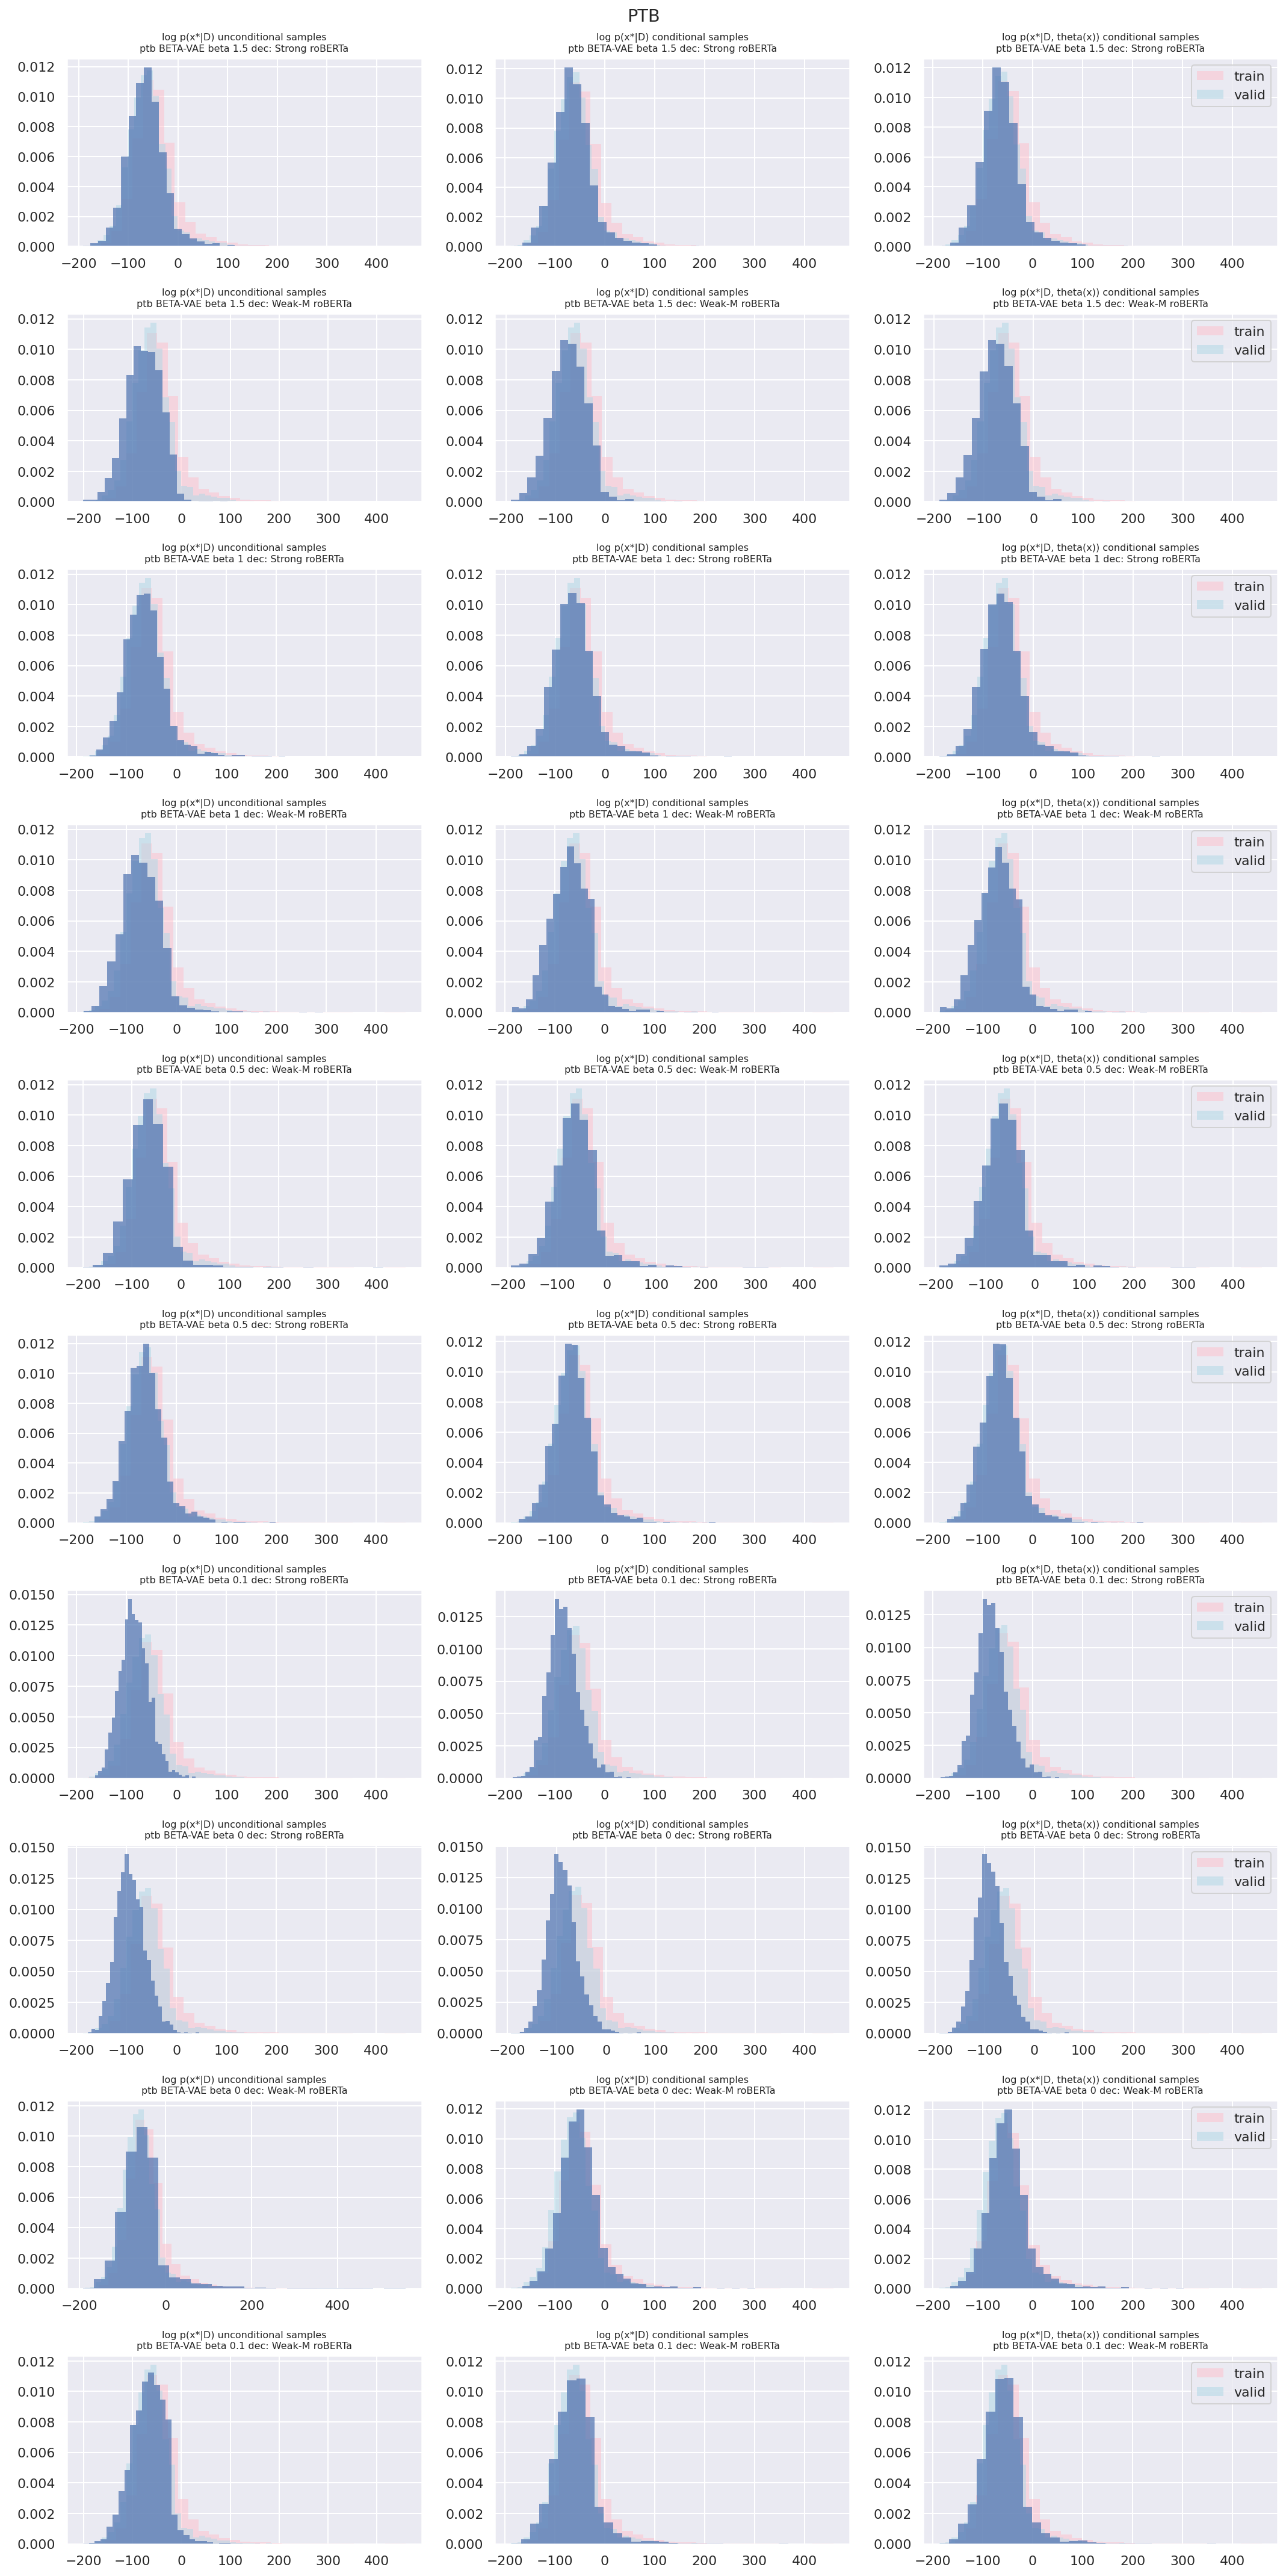

0 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
1 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
2 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa
3 yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa
4 yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa
5 yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa
6 yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa
7 yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa
8 yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa
9 yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa
10 yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa
11 yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa
12 yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa
13 yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa
14 yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa
15 yahoo_answer | dro

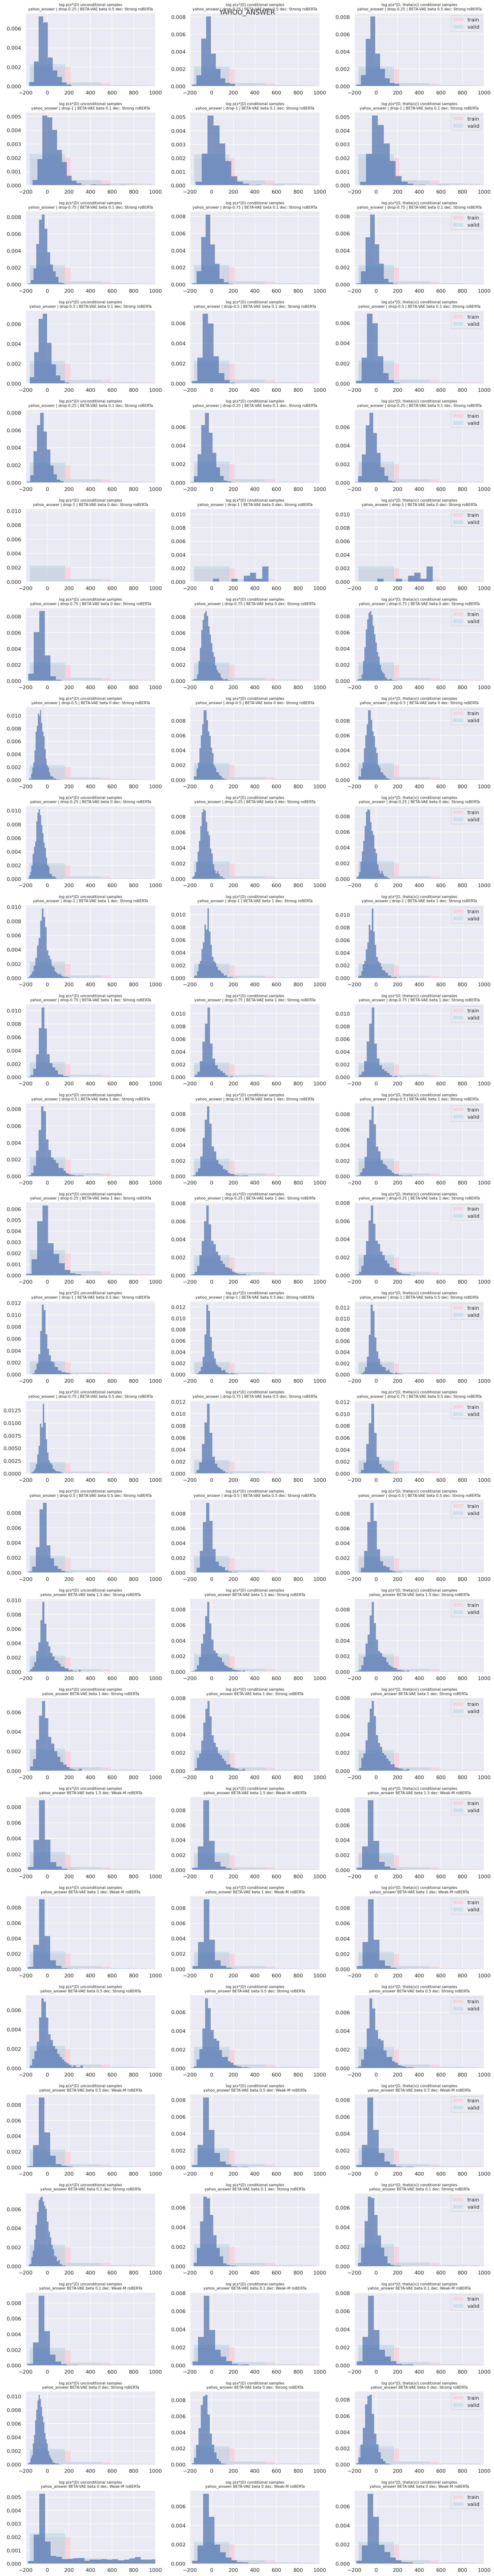

In [47]:
stat_name_dict = {
    "unconditional_unconditional": "log p(x*|D) unconditional samples",
    "unconditional_conditional": "log p(x*|D) conditional samples",
    "conditional_conditional": "log p(x*|D, theta(x)) conditional samples"
}

for dataset, log_p_w_stats in all_log_p_w_stats.items():
    N = len(log_p_w_stats) - 1 # minus data group
    
    ncols = 3
    nrows = N
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*3))
    
    for row, (model_name, stats) in enumerate(log_p_w_stats.items()):
        print(row, model_name)
        
        if "data_group" in model_name: continue
        
        for col, (k, v) in enumerate(stats.items()):

            axs[row, col].hist(log_p_w_stats["data_group"]["train"], label='train',
                               bins=30, density=True, alpha=0.5, color="pink", lw=0)
            axs[row, col].hist(log_p_w_stats["data_group"]["valid"], label='valid', 
                               bins=30, density=True, alpha=0.5, color="lightblue", lw=0)
            
            
            axs[row, col].hist(v, bins=30, density=True, alpha=0.7, color="b", lw=0)
            if dataset == 'yahoo_answer':
                axs[row, col].set_xlim([-200, 1000])
            
            axs[row, col].set_title(stat_name_dict[k] + "\n" + model_name, size=8)
            if col == 2:
                axs[row, col].legend()
    
    plt.suptitle(dataset.upper(), y=0.99)
    plt.tight_layout()
    plt.show()
    
#     break

# Old code

In [23]:
# # for model_name, samples in model_samples_transformed.items():
# for name, surprisal_mean in zip(names, means):
    
#     samples = model_samples_transformed[name]
#     print(name)
#     print("Surprisal mean:", surprisal_mean)
#     print("\n** Unconditional:\n")
    
#     for d, t in zip(samples["unconditional"]["docs"][:5], samples["unconditional"]["text_samples"][:5]):
#         print(d)
#         print(t)
#         print()
    
#     print()
#     print("\n** Conditional:\n")
    
#     for d, t in zip(samples["conditional_sampled_text"]["docs"][:5], samples["conditional_sampled_text"]["text_samples"][:5]):
#         print(d)
#         print(t)
#         print()
    
#     print()

# # model_name = "yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa"
# # model_samples_transformed[model_name]["unconditional"].keys() #["docs"] #[:30]

yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
Surprisal mean: 9.828904151916504

** Unconditional:

['okay', 'suppose', 'say', 'think', 'type', 'broadcast', 'program', 'attempting', 'quote', 'main', 'episode', 'nin', 'knowledge', 'show', 'quality', 'context', 'characterized', 'lack', 'good', 'conversion']
Okay I suppose you have to just say I think you are the type of broadcast program attempting to get you quotes up with your main episodes.\n\nIn my knowledge shows D is not all quality, that is a context. Usplots are characterized by the lack of good conversion. Also, (

['tip', 'building', 'neighborhood']
It'll tip building in your neighborhood too...

['yes', 'body', 'fat', 'lay', 'egg', 'top', 'making', 'food', 'left', 'behind']
Yes. Any body fat lay lay eggs on top of the egg. This is the "making from fat". It is the only food left behind.

['pat', 'wisconsin', 'http', 'www', 'com', 'feature', 'http_www']
Pat Gerard of Wisconsin\nSocialis Checkout: http://www.ge

KeyError: 'validation yahoo'

In [12]:
# def estimate_log_prob_lda(x_star_sparse, V, x_cond_sparse=None, N_theta=100, N_beta=100):
#     x_star_count_vecs = torch.FloatTensor(corpus2dense(x_star_sparse, num_terms=V).T)

#     # Conditioning on x* or on conditional if passed as input
#     if x_cond_sparse is not None:
#         x_cond_count_vecs = torch.FloatTensor(corpus2dense(x_cond_sparse, num_terms=V).T)
#     else:
#         x_cond_count_vecs = x_star_count_vecs
        
#     N_x, V = x_star_count_vecs.shape
#     num_tokens_per_doc = x_star_count_vecs.sum(dim=-1)
    
#     # Topic distributions theta
#     # [N_x, K]
#     gamma_matrix, _ = model.inference(chunk=x_star_sparse)

#     # [N_theta, N_x, K]
#     theta = td.Dirichlet(torch.Tensor(gamma_matrix)).sample((N_theta,))

#     # [N_theta, N_x, 1, K, 1]
#     log_theta = torch.log(theta)[:, :, None, :, None]

#     # Component distributions beta
#     # [K, V]
#     lamb = model.state.get_lambda()

#     # [N_beta, K, V]
#     beta = td.Dirichlet(torch.FloatTensor(lamb)).sample((N_beta,))

#     # [1, 1, N_beta, K, V]
#     log_beta = torch.log(beta)[None, None, :, :, :]
    
#     # Assess the log prob
#     # [N_theta, N_x, N_beta, K, V]
#     log_beta_theta = log_beta + log_theta

#     # [Nx, V] -> [1, N_x, 1, 1, V]
#     x_star_count_vecs = torch.Tensor(x_star_count_vecs)[None, :, None, None, :]

#     # [N_theta, N_x, N_beta, K]
#     # ( theta beta ) ** count = count log (theta beta)
#     log_beta_theta_counts = (log_beta_theta * x_star_count_vecs).sum(-1)

#     # [N_theta, N_x, N_beta]
#     log_prob = torch.logsumexp(log_beta_theta_counts, dim=-1)
    
#     # Reduce N_theta (0) and N_beta (-1) sample dims -> [N_x]
#     log_prob = torch.logsumexp(log_prob, dim=-1) - np.log(N_beta)
#     log_prob = torch.logsumexp(log_prob, dim=0) - np.log(N_theta)
    
#     # Divide by sum the counts per doc [N_x]
#     log_prob_per_token = log_prob / num_tokens_per_doc
    
#     return log_prob, log_prob_per_token

# def perform_estimate_log_prob_lda_in_batches(x_sparse, num_tokens, max_batches=None, N_x_batch=80, N_theta=30, N_beta=30):
#     if max_batches is None:
#         N_batches = int(np.ceil(len(unconditional_samples) / N_x_batch))
#     else:
#         N_batches = max_batches
        
#     print(f"{N_batches} batches of len {N_x_batch} for ~ {N_batches * N_x_batch} samples in total")
    
#     surprisals, surprisals_per_word = [], []
#     for batch_idx in range(N_batches):
#         print(f"batch: {batch_idx}/{N_batches}", end='\r')
        
#         batch = x_sparse[batch_idx*N_x_batch:(batch_idx+1)*N_x_batch]
        
#         batch_non_zero = [x for x in batch if len(x) != 0]
#         if len(batch_non_zero) == 0:
#             print("Batch contains zero length sequences only, skipping!")
#             continue
        
#         log_prob, log_prob_per_word = estimate_log_prob_lda(
#             x_star_sparse=batch_non_zero, 
#             V=num_tokens, 
#             x_cond_sparse=None, 
#             N_theta=N_theta, 
#             N_beta=N_beta)
        
#         surprisals.append(-log_prob)
#         surprisals_per_word.append(-log_prob_per_word)
    
#     return torch.cat(surprisals), torch.cat(surprisals_per_word)

In [15]:
# my first implementation, which is wrong
# import torch.distributions as td

# N_x = 20
# N_theta = 50
# N_beta = 30

# #-----------------------------------------------------

# # Sparse document format [[(token_id, count), ..., (token_id, count)]]
# x_star = model_corpus[:N_x] # lists of unequal length, with the token ids + counts

# # [N_x, V] with counts
# x_star_count_vectors = dense_corpus[:N_x]  

# # [N_x, V] with relative frequencies
# x_star_rel_count_vectors = torch.FloatTensor(dense_corpus[:N_x] / dense_corpus[:N_x].sum(axis=-1, keepdims=True))

# #-----------------------------------------------------
# # GAMMA -> THETA
# # [N_x, K]
# gamma_matrix, _ = model.inference(chunk=x_star)

# # [N_theta, N_x, K]
# theta = td.Dirichlet(torch.Tensor(gamma_matrix)).sample((N_theta,))

# # LAMBDA -> BETA
# # [K, V]
# lamb = model.state.get_lambda()

# # [N_beta, K, V]
# beta = td.Dirichlet(torch.FloatTensor(lamb)).sample((N_beta,))

# #-----------------------------------------------------
# # ASSESS LOG PROB of x* under the batched mixture
# # [N_theta, N_x, K] -> [1, N_theta, N_x, 1, K]
# theta_exp = theta[None, :, :, None, :]

# # [N_beta, K, V] -> [N_beta, 1, N_x, K, V]
# beta_exp = beta[:, None, None, :, :]

# # [N_beta, N_theta, N_x, V]
# mixed_probs = torch.matmul(theta_exp, beta_exp).squeeze(-2)

# # [N_x, V] -> [1, 1, N_x, V]
# x_star_rel_count_vectors = x_star_rel_count_vectors[None, None, :, :]

# # Adapted from: https://discuss.pytorch.org/t/catrogircal-cross-entropy-with-soft-classes/50871/2
# def CXE(predicted, target):
#     # sum over V = -1
#     return -(target * torch.log(predicted)).sum(dim=-1) 

# # Here the actual assessment of log probs is done by means of a cross entropy
# # [N_beta, N_theta, N_x]
# log_prob = CXE(predicted=x_star_rel_count_vectors, target=mixed_probs)

# # Reduce N_beta: [N_beta, N_theta, N_x] -> [N_theta, N_x]
# log_prob = torch.logsumexp(log_prob, 0) - np.log(N_beta)

# # Reduce N_theta: [N_theta, N_x] -> [N_x]
# log_prob = torch.logsumexp(log_prob, 0) - np.log(N_theta)

# print(log_prob.shape)
# print(log_prob)

# # tensor([ -643.4642,   -68.5219,  -566.8876,  -218.7951,  -740.1887, -1008.3533,
# #         -1023.3911,  -315.5319,  -427.6422,  -754.0059,  -901.0811,  -121.4755,
# #          -673.6902, -1256.5361,  -702.0944,  -434.0114,  -445.4697,  -102.0042,
# #          -494.2132,  -933.9154])

torch.Size([20])
tensor([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])


In [18]:
# Old code for Gensim LDA model

# # Train LDA model.
# from gensim.models import LdaModel

# # Set training parameters.
# num_topics = 10
# chunksize = 2000
# passes = 20
# iterations = 600
# eval_every = None  # Don't evaluate model perplexity, takes too much time.

# # Make a index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# model = LdaModel(
#     corpus=corpus,
#     id2word=id2word,
#     chunksize=chunksize,
#     alpha='auto',
#     eta='auto',
#     iterations=iterations,
#     num_topics=num_topics,
#     passes=passes,
#     eval_every=eval_every
# )

# from pprint import pprint

# # Print the Keyword in the 10 topics
# yahoo_topics = """Society & Culture
# Science & Mathematics
# Health
# Education & Reference
# Computers & Internet
# Sports
# Business & Finance
# Entertainment & Music
# Family & Relationships
# Politics & Government"""
# print(yahoo_topics)
# pprint(model.print_topics())

# # Compute Perplexity
# # print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# print()
# doc_lda = model[corpus[:10]]

# for i in range(10):
#     print(docs[i])
#     print(doc_lda[i])

In [ ]:
# N, D = dense_corpus.shape

# # The input below, X, is a document-term matrix (sparse matrices are accepted
# X = np.int64(dense_corpus)

# LDA_model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
# LDA_model.fit(X)

In [25]:
# import torch.distributions as td

# S = 50
# Sx = 100

# # Posterior beta samples (component distributions) [Sb, K, V]
# lamb = model.state.get_lambda()
# beta = td.Dirichlet(torch.FloatTensor(lamb)).sample((S,)).unsqueeze(1).repeat(1, Sx, 1, 1)
# comp = td.Categorical(probs=beta)
# print("Shape beta (comp), should be [B, T, D]", beta.shape)
# print("comp.batch_shape", comp.batch_shape)

# # Posterior theta samples (topic distributions) [St, Sx, K]
# gamma, _ = model.inference(corpus[:Sx], collect_sstats=False)
# theta = td.Dirichlet(torch.FloatTensor(gamma)).sample((S,))
# mix = td.Categorical(probs=theta)
# print("Shape theta (mix), should be [B, T]", theta.shape)
# print("mix.batch_shape", mix.batch_shape)

# mixture_model = td.MixtureSameFamily(mix, comp)
# print("Mixture:", mixture_model)
# s = mixture_model.sample()

# toy_x = torch.Tensor([10, 40, 40, 50]).long()
# toy_p_x = mixture_model.log_prob(toy_x[:, None, None]).sum(dim=0)


# logsumexp

Shape beta (comp), should be [B, T, D] torch.Size([50, 100, 10, 4007])
comp.batch_shape torch.Size([50, 100, 10])
Shape theta (mix), should be [B, T] torch.Size([50, 100, 10])
mix.batch_shape torch.Size([50, 100])
Mixture: MixtureSameFamily(
  Categorical(probs: torch.Size([50, 100, 10]), logits: torch.Size([50, 100, 10])),
  Categorical(probs: torch.Size([50, 100, 10, 4007])))


torch.Size([4, 50, 100])